# Engram-xkjd zh XKJD keyboard layout

Engram-xkjd is a key layout optimized for comfortable and efficient touch typing in Spanish 
created by [Arno Klein](https://binarybottle.com) with help from Ian Douglas, aMiguel Guzmán, and Nick Gutiérrez.

based on the original English Engram [open source code](https://github.com/binarybottle/engram).


# Contents
1. [Why a new keyboard layout?](#why)
2. [Guiding criteria](#criteria)
3. Setup:
    - [Dependencies and functions](#import)
    - [Speed matrix](#speed)
    - [Strength matrix](#strength)
    - [Flow matrix and Engram scoring model](#flow)
4. Steps:
    - [Step 1: Define the shape of the key layout to minimize lateral finger movements](#step1)
    - [Step 2: Arrange the most frequent letters based on comfort and bigram frequencies](#step2)
    - [Step 3: Optimize assignment of the remaining letters](#step3)
    - [Step 4: Evaluate winning layout](#step4)
    - [Step 5: Arrange non-letter characters in easy-to-remember places](#step5)

## Why a new keyboard layout? <a name="why">

**History** <br>
After creating the [English Engram layout](https://engram.dev) ([open source code](https://github.com/binarybottle/engram)), community members came together to help guide the creation of a Spanish version.  Thank you, Nick Gutiérrez (@NickG13) and Miguel Guzmán (@Lobo-Feroz), and a special thanks to Ian Douglas (@iandoug) for cleaning up the Leipzig Spanish corpus and for computing character and bigram frequencies!  For documentation of this Spanish corpus, please see [Creating a Corpus and Chained Bigrams for Spanish Keyboard Development and Evaluation](https://zenodo.org/record/5501931).

**Why "Engram"?** <br>
The name is a pun, referring both to "n-gram", letter permutations and their frequencies that are used to compute the Engram layout, and "engram", or memory trace, the postulated change in neural tissue to account for the persistence of memory, as a nod to my attempt to make this layout easy to remember.

## Guiding criteria   <a name="criteria">

    1.  Assign letters to keys that don't require lateral finger movements.
    2.  Promote alternating between hands over uncomfortable same-hand transitions.
    3.  Assign the most common letters to the most comfortable keys.
    4.  Arrange letters so that more frequent bigrams are easier to type.
    5.  Promote little-to-index-finger roll-ins over index-to-little-finger roll-outs.
    6.  Balance finger loads according to their relative strength.
    7.  Avoid stretching shorter fingers up and longer fingers down.
    8.  Avoid using the same finger.
    9.  Avoid skipping over the home row.
    10. Assign the most common punctuation to keys in the middle of the keyboard.
    11. Assign easy-to-remember symbols to the Shift-number keys.
    
### Factors used to compute the Engram layout <a name="factors">
  - Spanish letter and letter bigram frequency data from a cleaned-up version of the Leipzig Spanish corpus. The largest file was downloaded from each row of the [original version](https://wortschatz.uni-leipzig.de/en/download/Spanish), except for rows specified as not from Spain, and lines containing non-Spanish names and words were removed.
    <br>
  - **Flow factors** (transitions between ordered key pairs)

### Import dependencies and functions  <a name="import">

In [1]:
# %load code/engram_variables.py
# Print .png figures and .txt text files
print_output = False # True

# Apply strength data
apply_strength = True
min_strength_factor = 0.9

letters24 = ['E', 'T', 'D', 'I', 'O', 'A', 'N', 'L', 'H', 'S', 'R', 'Y', 'J', 'F', 'U', 'V', 'M', 'B', 'W', 'K', 'G', 'Q', 'X',  'P',]
keys24 = [1,2,3,4, 5,6,7,8, 9,10,11,12, 13,14,15,16, 17,18,19,20, 21,22,23,24]
instances24 = [5656686434.0, 3696032427.3333335, 3647911315.333333, 3511880602.6666665, 3508811514.0, 3384295675.0, 3015194187.6666665, 2815640378.0, 2801195235.0, 2742872753.0, 2588302146.333333, 2529431956.4333334, 2229882837.9166665, 2017992101.9083333, 1915687775.225, 1782801744.1666667, 1736556854.7083335, 1706238601.1083333, 1697871454.1666667, 1680497961.275, 1649105542.2666667, 1579443466.9083333, 1507883577.95,  1168331081.4083333]


max_frequency = 5656686434
instances_denominator = 1e+08

# Establish which layouts are within a small difference of the top-scoring layout 
# (the smallest difference between two penalties, 0.9^8 - 0.9^9, in one of 24^2 key pairs):
delta = 0.9**8 - 0.9**9
factor24 = ((24**2 - 1) + (1-delta)) / (24**2)
factor32 = ((32**2 - 1) + (1-delta)) / (32**2)

# Establish which layouts are within a small difference of each other when using the speed matrix. 
# We define an epsilon equal to 13.158 ms for a single bigram (of the 32^2 possible bigrams), 
# where 13.158 ms is one tenth of 131.58 ms, the fastest measured digraph tapping speed (30,000/228 = 131.58 ms) 
# recorded in the study: "Estimation of digraph costs for keyboard layout optimization", 
# A Iseri, Ma Eksioglu, International Journal of Industrial Ergonomics, 48, 127-138, 2015.
#data_matrix_speed = Speed32x32
#time_range = 243  # milliseconds
#norm_range = np.max(data_matrix_speed) - np.min(data_matrix_speed)  # 0.6535662299854439
#ms_norm = norm_range / time_range  # 0.0026895729629030614
#epsilon = 131.58/10 * ms_norm / (32**2)
epsilon    = 0.00003549615849447514

In [2]:
# %load code/engram_functions.py
# Import dependencies
import numpy as np
from sympy.utilities.iterables import multiset_permutations
import matplotlib
import matplotlib.pyplot as plt    
import seaborn as sns


def permute_optimize_keys(fixed_letters, fixed_letter_indices, open_letter_indices, 
                          all_letters, keys, data_matrix, bigrams, bigram_frequencies, 
                          min_score=0, verbose=False):
    """
    Find all permutations of letters, optimize layout, and generate output.
    """
    matrix_selected = select_keys(data_matrix, keys, verbose=False) 
    
    unassigned_letters = []
    for all_letter in all_letters:
        if all_letter not in fixed_letters:
            unassigned_letters.append(all_letter)
            if len(unassigned_letters) == len(open_letter_indices):
                break

    letter_permutations = permute_letters(unassigned_letters, verbose)
    if verbose:
        print("{0} permutations".format(len(letter_permutations)))
    top_permutation, top_score = optimize_layout(np.array([]), matrix_selected, bigrams, bigram_frequencies, 
                                                 letter_permutations, open_letter_indices, 
                                                 fixed_letters, fixed_letter_indices, min_score, verbose)
    
    return top_permutation, top_score, letter_permutations


def permute_optimize(starting_permutation, letters, all_letters, all_keys, 
                     data_matrix, bigrams, bigram_frequencies, min_score=0, verbose=False):
    """
    Find all permutations of letters, optimize layout, and generate output.
    """
    matrix_selected = select_keys(data_matrix, all_keys, verbose=False)
    open_positions = []
    fixed_positions = [] 
    open_letters = []
    fixed_letters = []
    assigned_letters = []
    for iletter, letter in enumerate(letters):
        if letter.strip() == "":
            open_positions.append(iletter)
            for all_letter in all_letters:
                if all_letter not in letters and all_letter not in assigned_letters:
                    open_letters.append(all_letter)
                    assigned_letters.append(all_letter)
                    break
        else:
            fixed_positions.append(iletter)
            fixed_letters.append(letter)

    letter_permutations = permute_letters(open_letters, verbose)
    if verbose:
        print("{0} permutations".format(len(letter_permutations)))
    top_permutation, top_score = optimize_layout(starting_permutation, matrix_selected, bigrams, 
                                                 bigram_frequencies, letter_permutations, open_positions, 
                                                 fixed_letters, fixed_positions, min_score, verbose)
        
    return top_permutation, top_score


def select_keys(data_matrix, keys, verbose=False):
    """
    Select keys to quantify pairwise relationships.
    """
    # Extract pairwise entries for the keys:
    nkeys = len(keys)
    Select = np.zeros((nkeys, nkeys))
    u = 0
    for i in keys:
        u += 1
        v = 0
        for j in keys:
            v += 1
            Select[u-1,v-1] = data_matrix[i-1,j-1]

    # Normalize matrix with min-max scaling to a range with max 1:
    newMin = np.min(Select) / np.max(Select)
    newMax = 1.0
    Select = newMin + (Select - np.min(Select)) * (newMax - newMin) / (np.max(Select) - np.min(Select))
    
    if verbose:
        # Heatmap of array
        heatmap(data=Select, title="Matrix heatmap", xlabel="Key 1", ylabel="Key 2", print_output=False); plt.show()
    
    return Select


def permute_letters(letters, verbose=False):
    """
    Find all permutations of a given set of letters (max: 8-10 letters).
    """
    letter_permutations = []
    for p in multiset_permutations(letters):
        letter_permutations.append(p)
    letter_permutations = np.array(letter_permutations)
    
    return letter_permutations


def score_layout(data_matrix, letters, bigrams, bigram_frequencies, verbose=False):
    """
    Compute the score for a given letter-key layout (NOTE normalization step).
    """
    # Create a matrix of bigram frequencies:
    nletters = len(letters)
    F2 = np.zeros((nletters, nletters))

    # Find the bigram frequency for each ordered pair of letters in the permutation:
    for i1 in range(nletters):
        for i2 in range(nletters):
            bigram = letters[i1] + letters[i2]
            i2gram = np.where(bigrams == bigram)
            if np.size(i2gram) > 0:
                F2[i1, i2] = bigram_frequencies[i2gram][0]

    # Normalize matrices with min-max scaling to a range with max 1:
    newMax = 1
    minF2 = np.min(F2)
    maxF2 = np.max(F2)
    newMin2 = minF2 / maxF2
    F2 = newMin + (F2 - minF2) * (newMax - newMin2) / (maxF2 - minF2)

    # Compute the score for this permutation:
    score  = np.average(data_matrix * F2) 
    if verbose:
        print("Score for letter permutation {0}: {1}".format(letters, score))

    return score


def tally_bigrams(input_text, bigrams, normalize=True, verbose=False):
    """
    Compute the score for a given letter-key layout (NOTE normalization step).
    """   
    # Find the bigram frequency for each ordered pair of letters in the input text
    #input_text = [str.upper(str(x)) for x in input_text]
    input_text = [str.upper(x) for x in input_text]
    nchars = len(input_text)
    F = np.zeros(len(bigrams))

    for ichar in range(0, nchars-1):
        bigram = input_text[ichar] + input_text[ichar + 1]
        i2gram = np.where(bigrams == bigram)
        if np.size(i2gram) > 0:
            F[i2gram] += 1

    # Normalize matrix with min-max scaling to a range with max 1:
    if normalize:
        newMax = 1
        newMin = np.min(F) / np.max(F)
        F = newMin + (F - np.min(F)) * (newMax - newMin) / (np.max(F) - np.min(F))

    bigram_frequencies_for_input = F

    if verbose:
        print("Bigram frequencies for input: {0}".format(bigram_frequencies_for_input))

    return bigram_frequencies_for_input


def tally_layout_samefinger_bigrams(layout, bigrams, bigram_frequencies, nkeys=32, verbose=False):
    """
    Tally the number of same-finger bigrams within (a list of 24 letters representing) a layout:
    ['P','Y','O','U','C','I','E','A','G','K','J','X','M','D','L','B','R','T','N','S','H','V','W','F']
    """  
    if nkeys == 32:
        #        Left:            Right:
        #    1  2  3  4 25   28 13 14 15 16 31 
        #    5  6  7  8 26   29 17 18 19 20 32
        #    9 10 11 12 27   30 21 22 23 24
        same_finger_keys = [[1,5],[5,9],[1,9], [2,6],[6,10],[2,10], 
                            [3,7],[7,11],[3,11], [4,8],[8,12],[4,12],
                            [25,26],[26,27],[25,27], [28,29],[29,30],[28,30], [31,32],
                            [4,25],[4,26],[4,27], [8,25],[8,26],[8,27], [12,25],[12,26],[12,27],
                            [13,28],[13,29],[13,30], [17,28],[17,29],[17,30], [21,28],[21,29],[21,30],
                            [31,16],[31,20],[31,24], [32,16],[32,20],[32,24],
                            [13,17],[17,21],[13,21], [14,18],[18,22],[14,22], 
                            [15,19],[19,23],[15,23], [16,20],[20,24],[16,24]] 
    elif nkeys == 24:
        #    1  2  3  4         13 14 15 16  
        #    5  6  7  8         17 18 19 20 
        #    9 10 11 12         21 22 23 24
        same_finger_keys = [[1,5],[5,9],[1,9], [2,6],[6,10],[2,10], 
                            [3,7],[7,11],[3,11], [4,8],[8,12],[4,12],
                            [13,17],[17,21],[13,21], [14,18],[18,22],[14,22], 
                            [15,19],[19,23],[15,23], [16,20],[20,24],[16,24]] 

    layout = [str.upper(x) for x in layout]
    max_frequency = 1.00273E+11

    samefinger_bigrams = []
    samefinger_bigram_counts = []
    for bigram_keys in same_finger_keys:
        bigram1 = layout[bigram_keys[0]-1] + layout[bigram_keys[1]-1]
        bigram2 = layout[bigram_keys[1]-1] + layout[bigram_keys[0]-1]
        i2gram1 = np.where(bigrams == bigram1)
        i2gram2 = np.where(bigrams == bigram2)
        if np.size(i2gram1) > 0:
            samefinger_bigrams.append(bigram1)
            samefinger_bigram_counts.append(max_frequency * bigram_frequencies[i2gram1] / np.max(bigram_frequencies))
        if np.size(i2gram2) > 0:
            samefinger_bigrams.append(bigram2)
            samefinger_bigram_counts.append(max_frequency * bigram_frequencies[i2gram2] / np.max(bigram_frequencies))

    samefinger_bigrams_total = np.sum([x[0] for x in samefinger_bigram_counts])

    if verbose:
        print("    Total same-finger bigram frequencies: {0:15.0f}".format(samefinger_bigrams_total))

    return samefinger_bigrams, samefinger_bigram_counts, samefinger_bigrams_total 


def tally_layout_bigram_rolls(layout, bigrams, bigram_frequencies, nkeys=32, verbose=False):
    """
    Tally the number of bigrams that engage little-to-index finger inward rolls
    for (a list of 24 or 32 letters representing) a layout,
    within the four columns of one hand, or any column across two hands.
    layout = ['P','Y','O','U','C','I','E','A','G','K','J','X','L','D','B','V','N','T','R','S','H','M','W','F']
    bigram_rolls, bigram_roll_counts, bigram_rolls_total = tally_layout_bigram_rolls(layout, bigrams, bigram_frequencies, nkeys=24, verbose=True)
    """   
    if nkeys == 32:
        #        Left:            Right:
        #    1  2  3  4 25   28 13 14 15 16 31 
        #    5  6  7  8 26   29 17 18 19 20 32
        #    9 10 11 12 27   30 21 22 23 24

        roll_keys = [[1,2],[2,3],[3,4], [5,6],[6,7],[7,8], [9,10],[10,11],[11,12],
                    [16,15],[15,14],[14,13], [20,19],[19,18],[18,17], [24,23],[23,22],[22,21],
                    [1,3],[2,4],[1,4], [5,7],[6,8],[5,8], [9,11],[10,12],[9,12],
                    [16,14],[15,13],[16,13], [20,18],[19,17],[20,17], [24,22],[23,21],[24,21],
                    [1,6],[1,7],[1,8],[2,7],[2,8],[3,8], 
                    [5,2],[5,3],[5,4],[6,3],[6,4],[7,4],
                    [5,10],[5,11],[5,12],[6,11],[6,12],[7,12], 
                    [9,6],[9,7],[9,8],[10,7],[10,8],[11,8],
                    [16,19],[16,18],[16,17],[15,18],[15,17],[14,17], 
                    [20,15],[20,14],[20,13],[19,14],[19,13],[18,13],
                    [20,23],[20,22],[20,21],[19,22],[19,21],[18,21], 
                    [24,19],[24,18],[24,17],[23,18],[23,17],[22,17],
                    [1,10],[1,11],[1,12],[2,11],[2,12],[3,12],
                    [9,2],[9,3],[9,4],[10,3],[10,4],[11,4],
                    [16,23],[16,22],[16,21],[15,22],[15,21],[14,21],
                    [24,15],[24,14],[24,13],[23,14],[23,13],[22,13]]
        for i in [1,2,3,4,5,6,7,8,9,10,11,12, 25,26,27]:
            for j in [13,14,15,16,17,18,19,20,21,22,23,24, 28,29,30,31,32]:
                roll_keys.append([i,j])
        for i in [13,14,15,16,17,18,19,20,21,22,23,24, 28,29,30,31,32]:
            for j in [1,2,3,4,5,6,7,8,9,10,11,12, 25,26,27]:
                roll_keys.append([i,j])

    elif nkeys == 24:
        #    1  2  3  4         13 14 15 16  
        #    5  6  7  8         17 18 19 20 
        #    9 10 11 12         21 22 23 24
        roll_keys = [[1,2],[2,3],[3,4], [5,6],[6,7],[7,8], [9,10],[10,11],[11,12],
                    [16,15],[15,14],[14,13], [20,19],[19,18],[18,17], [24,23],[23,22],[22,21],
                    [1,3],[2,4],[1,4], [5,7],[6,8],[5,8], [9,11],[10,12],[9,12],
                    [16,14],[15,13],[16,13], [20,18],[19,17],[20,17], [24,22],[23,21],[24,21],
                    [1,6],[1,7],[1,8],[2,7],[2,8],[3,8], [5,2],[5,3],[5,4],[6,3],[6,4],[7,4],
                    [5,10],[5,11],[5,12],[6,11],[6,12],[7,12], [9,6],[9,7],[9,8],[10,7],[10,8],[11,8],
                    [16,19],[16,18],[16,17],[15,18],[15,17],[14,17], [20,15],[20,14],[20,13],[19,14],[19,13],[18,13],
                    [20,23],[20,22],[20,21],[19,22],[19,21],[18,21], [24,19],[24,18],[24,17],[23,18],[23,17],[22,17],
                    [1,10],[1,11],[1,12],[2,11],[2,12],[3,12], [9,2],[9,3],[9,4],[10,3],[10,4],[11,4],
                    [16,23],[16,22],[16,21],[15,22],[15,21],[14,21], [24,15],[24,14],[24,13],[23,14],[23,13],[22,13]]
        for i in range(0,12):
            for j in range(12,24):
                roll_keys.append([i,j])
        for i in range(12,24):
            for j in range(0,12):
                roll_keys.append([i,j])

    layout = [str.upper(x) for x in layout]
    max_frequency = 1.00273E+11

    bigram_rolls = []
    bigram_roll_counts = []
    for bigram_keys in roll_keys:
        bigram1 = layout[bigram_keys[0]-1] + layout[bigram_keys[1]-1]
        bigram2 = layout[bigram_keys[1]-1] + layout[bigram_keys[0]-1]
        i2gram1 = np.where(bigrams == bigram1)
        i2gram2 = np.where(bigrams == bigram2)
        if np.size(i2gram1) > 0:
            bigram_rolls.append(bigram1)
            bigram_roll_counts.append(max_frequency * bigram_frequencies[i2gram1] / np.max(bigram_frequencies))
        if np.size(i2gram2) > 0:
            bigram_rolls.append(bigram2)
            bigram_roll_counts.append(max_frequency * bigram_frequencies[i2gram2] / np.max(bigram_frequencies))

    bigram_rolls_total = np.sum([x[0] for x in bigram_roll_counts])

    if verbose:
        print("    Total bigram inward roll frequencies: {0:15.0f}".format(bigram_rolls_total))

    return bigram_rolls, bigram_roll_counts, bigram_rolls_total 


def optimize_layout(starting_permutation, data_matrix, bigrams, bigram_frequencies, letter_permutations, 
                    open_positions, fixed_letters, fixed_positions=[], min_score=0, verbose=False):
    """
    Compute scores for all letter-key layouts.
    """
    top_permutation = starting_permutation
    top_score = min_score
    use_score_function = False

    nletters = len(open_positions) + len(fixed_positions)
    F2 = np.zeros((nletters, nletters))

    # Loop through the permutations of the selected letters:
    for p in letter_permutations:
        letters = np.array(['W' for x in range(nletters)])  # KEEP to initialize!
        for imove, open_position in enumerate(open_positions):
            letters[open_position] = p[imove]
        for ifixed, fixed_position in enumerate(fixed_positions):
            letters[fixed_position] = fixed_letters[ifixed]

        # Compute the score for this permutation:
        if use_score_function:
            score = score_layout(data_matrix, letters, bigrams, bigram_frequencies, verbose=False)
        else:
            # Find the bigram frequency for each ordered pair of letters in the permutation:
            for i1 in range(nletters):
                for i2 in range(nletters):
                    bigram = letters[i1] + letters[i2]
                    i2gram = np.where(bigrams == bigram)
                    if np.size(i2gram) > 0:
                        F2[i1, i2] = bigram_frequencies[i2gram][0]

            # Normalize matrices with min-max scaling to a range with max 1:
            newMax = 1
            minF2 = np.min(F2)
            maxF2 = np.max(F2)
            newMin2 = minF2 / maxF2
            F = newMin + (F2 - minF2) * (newMax - newMin2) / (maxF2 - minF2)

            # Compute the score for this permutation:
            score  = np.average(data_matrix * F) 

        if score > top_score:
            top_score = score
            top_permutation = letters
            
    if verbose:
        if top_score == min_score:
            print("top_score = min_score")
        print("{0:0.8f}".format(top_score))
        print(*top_permutation)
        
    return top_permutation, top_score


def exchange_letters(letters, fixed_letter_indices, all_letters, all_keys, data_matrix, 
                     bigrams, bigram_frequencies, verbose=True):
    """
    Exchange letters, 8 keys at a time (8! = 40,320) selected twice in 14 different ways:

    Indices:
         0  1  2  3     12 13 14 15
         4  5  6  7     16 17 18 19
         8  9 10 11     20 21 22 23 

    1. Top rows
         0  1  2  3     12 13 14 15
    2. Bottom rows
         8  9 10 11     20 21 22 23 
    3. Top and bottom rows on the right side
                        12 13 14 15
                        20 21 22 23 
    4. Top and bottom rows on the left side 
         0  1  2  3
         8  9 10 11 
    5. Top right and bottom left rows
                        12 13 14 15
         8  9 10 11 
    6. Top left and bottom right rows 
         0  1  2  3
                        20 21 22 23 
    7. Center of the top and bottom rows on both sides
            1  2          13 14
            9 10          21 22
    8. The eight corners
         0        3    12       15
         8       11    20       23 
    9. Left half of the top and bottom rows on both sides 
         0  1          12 13
         8  9          20 21
    10. Right half of the top and bottom rows on both sides
               2  3          14 15
              10 11          22 23 
    11. Left half of non-home rows on the left and right half of the same rows on the right 
         0  1                14 15
         8  9                22 23 
    12. Right half of non-home rows on the left and left half of the same rows on the right
               2  3    12 13
              10 11    20 21 
    13. Top center and lower sides
            1  2           13 14
         8       11     20       23 
    14. Top sides and lower center
         0        3     12       15
            9 10           21 22   
    15. Repeat 1-14

    """
    top_score = score_layout(data_matrix, letters, bigrams, bigram_frequencies, verbose=False)
    print('Initial score: {0}'.format(top_score)) 
    print(*letters) 
    top_permutation = letters

    lists_of_open_indices = [
        [0,1,2,3,12,13,14,15],
        [8,9,10,11,20,21,22,23],
        [12,13,14,15,20,21,22,23],
        [0,1,2,3,8,9,10,11],
        [12,13,14,15,8,9,10,11],
        [0,1,2,3,20,21,22,23],
        [1,2,13,14,9,10,21,22],
        [0,3,12,15,8,11,20,23],
        [0,1,12,13,8,9,20,21],
        [2,3,14,15,10,11,22,23],
        [0,1,14,15,8,9,22,23],
        [2,3,12,13,10,11,20,21],
        [1,2,8,11,13,14,20,23],
        [0,3,9,10,12,15,21,22]  
    ]
    lists_of_print_statements = [
        '1. Top rows',
        '2. Bottom rows',
        '3. Top and bottom rows on the right side',
        '4. Top and bottom rows on the left side',
        '5. Top right and bottom left rows',
        '6. Top left and bottom right rows',
        '7. Center of the top and bottom rows on both sides',
        '8. The eight corners',
        '9. Left half of the top and bottom rows on both sides',
        '10. Right half of the top and bottom rows on both sides',
        '11. Left half of non-home rows on the left and right half of the same rows on the right',
        '12. Right half of non-home rows on the left and left half of the same rows on the right',
        '13. Top center and lower sides',
        '14. Top sides and lower center'
    ]
                         
    for istep in [1,2]:
        if istep == 1:
            s = "Set 1: 14 letter exchanges: "
        elif istep == 2:
            s = "Set 2: 14 letter exchanges: "

        for ilist, open_indices in enumerate(lists_of_open_indices):
            print_statement = lists_of_print_statements[ilist]     

            if verbose:
                print('{0} {1}'.format(s, print_statement))
              
            starting_permutation = top_permutation.copy()
            for open_index in open_indices:
                if open_index not in fixed_letter_indices:
                    top_permutation[open_index] = ''
            
            top_permutation, top_score = permute_optimize(starting_permutation, top_permutation, letters24, 
                                                          keys24, data_matrix, bigrams, bigram_frequencies, 
                                                          min_score=top_score, verbose=True)                    
    if verbose:
        print('')
        print('    -------- DONE --------') 
        print('')

    return top_permutation, top_score
                             

def rank_within_epsilon(numbers, epsilon, factor=False, verbose=True):
    """
    numbers = np.array([10,9,8,7,6])
    epsilon = 1
    rank_within_epsilon(numbers, epsilon, factor=False, verbose=True) 
    >>> array([1., 1., 2., 2., 3.])
    numbers = np.array([0.798900824, 0.79899900824, 0.79900824])
    epsilon = 0.9**8 - 0.9**9
    factor24 = ((24**2 - 1) + (1-epsilon)) / (24**2) # 0.999925266109375
    rank_within_epsilon(numbers, factor24, factor=True, verbose=True) 
    >>> array([2., 1., 1.])
    """
    numbers = np.array(numbers)
    Isort = np.argsort(-numbers)
    numbers_sorted = numbers[Isort]
    count = 1
    ranks = np.zeros(np.size(numbers))
    for i, num in enumerate(numbers_sorted):
        if ranks[i] == 0:
            if factor:
                lower_bound = num * epsilon
            else:
                lower_bound = num - epsilon
            bounded_nums1 = num >= numbers_sorted
            bounded_nums2 = numbers_sorted >= lower_bound
            bounded_nums = bounded_nums1 * bounded_nums2
            count += 1
            for ibounded, bounded_num in enumerate(bounded_nums):
                if bounded_num == True:
                    ranks[ibounded] = count

    uranks = np.unique(ranks)
    nranks = np.size(uranks)
    new_ranks = ranks.copy()
    new_count = 0
    for rank in uranks:
        new_count += 1
        same_ranks = ranks == rank
        for isame, same_rank in enumerate(same_ranks):
            if same_rank == True:
                new_ranks[isame] = new_count

    #ranks_sorted = new_ranks[Isort]
    ranks_sorted = [np.int_(x) for x in new_ranks]
    
    if verbose:
        for i, num in enumerate(numbers_sorted):
            print("    ({0})    {1}".format(np.int_(ranks_sorted[i]), num))
        
    return numbers_sorted, ranks_sorted, Isort


def print_matrix_info(matrix_data, matrix_label, nkeys, nlines=10):
    """
    Print matrix output.
    """
    print("{0} min = {1}, max = {2}".format(matrix_label, np.min(matrix_data), np.max(matrix_data)))
    matrix_flat = matrix_data.flatten()
    argsort = np.argsort(matrix_flat)
    print("{0} key number pairs with minimum values:".format(matrix_label))
    for x in argsort[0:nlines]:
        if x % nkeys == 0:
            min_row = np.int_(np.ceil(x / nkeys)) + 1
            min_col = 1
        else:
            min_row = np.int_(np.ceil(x / nkeys))
            min_col = x - nkeys * (min_row-1) + 1                
        print("        {0} -> {1}        ({2})".format(min_row, min_col, matrix_flat[x]))
    print("{0} key number pairs with maximum values:".format(matrix_label))
    max_sort = argsort[-nlines::]
    for x in max_sort[::-1]:
        if x % nkeys == 0:
            max_row = np.int_(np.ceil(x / nkeys)) + 1
            max_col = 1
        else:
            max_row = np.int_(np.ceil(x / nkeys))
            max_col = x - nkeys * (max_row-1) + 1                
        print("        {0} -> {1}        ({2})".format(max_row, max_col, matrix_flat[x]))


def heatmap(data, title="", xlabel="", ylabel="", x_axis_labels=[], y_axis_labels=[], print_output=True):
    """
    Plot heatmap of matrix.
    """
    # use heatmap function, set the color as viridis and
    # make each cell seperate using linewidth parameter
    plt.figure()
    sns_plot = sns.heatmap(data, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidths=1, 
                           cmap="viridis", square=True, vmin=np.min(data), vmax=np.max(data))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    sns_plot.set_xticklabels(x_axis_labels)  #, rotation=75) 
    sns_plot.set_yticklabels(y_axis_labels) 
    if print_output:
        sns_plot.figure.savefig("{0}_heatmap.png".format(title))
        
    
def histmap(data, title="", print_output=True):
    """
    Plot histogram.
    """
    sns.distplot(data)
    plt.title(title)
    if print_output:
        sns_plot.figure.savefig("{0}_histogram.png".format(title))
        
        
def print_layout24(layout):
    """
    Print layout.
    """   
    print('    {0}  {1}'.format(' '.join(layout[0:4]),
                                ' '.join(layout[12:16])))
    print('    {0}  {1}'.format(' '.join(layout[4:8]),
                                ' '.join(layout[16:20])))
    print('    {0}  {1}'.format(' '.join(layout[8:12]),
                                ' '.join(layout[20:24])))


def print_layout24_instances(layout, letters24, instances24, bigrams, bigram_frequencies):
    """
    Print billions of instances per letter (not Z or Q) in layout form.
    layout = ['P','Y','O','U','C','I','E','A','G','K','J','X','M','D','L','B','R','T','N','S','H','V','W','F']
    print_layout24_instances(layout, letters24, instances24, bigrams, bigram_frequencies)
    """
    layout_instances = []
    layout_instances_strings = []
    for letter in layout:
        index = letters24.index(letter)
        layout_instances.append(instances24[index])
        layout_instances_strings.append('{0:3.0f}'.format(instances24[index]/instances_denominator))
 
    print('    {0}  {1}'.format(' '.join(layout_instances_strings[0:4]),
                                ' '.join(layout_instances_strings[12:16])))
    print('    {0}  {1}'.format(' '.join(layout_instances_strings[4:8]),
                                ' '.join(layout_instances_strings[16:20])))
    print('    {0}  {1}'.format(' '.join(layout_instances_strings[8:12]),
                                ' '.join(layout_instances_strings[20:24])))
    left_sum = np.sum(layout_instances[0:12])
    right_sum = np.sum(layout_instances[12:24])
    pL = ''
    pR = ''
    if left_sum > right_sum:
        pL = ' ({0:3.2f}%)'.format(100 * (left_sum - right_sum) / right_sum)
    elif right_sum > left_sum:
        pR = ' ({0:3.2f}%)'.format(100 * (right_sum - left_sum) / left_sum)
    
    print('\n    left: {0}{1}  right: {2}{3}'.format(left_sum, pL, right_sum, pR))
    
    tally_layout_samefinger_bigrams(layout, bigrams, bigram_frequencies, nkeys=24, verbose=True)
    tally_layout_bigram_rolls(layout, bigrams, bigram_frequencies, nkeys=24, verbose=True)
   

def print_bigram_frequency(input_pair, bigrams, bigram_frequencies):
    """
    >>> print_bigram_frequency(['t','h'], bigrams, bigram_frequencies)
    """
    # Find the bigram frequency
    input_text = [str.upper(str(x)) for x in input_pair]
    nchars = len(input_text)
    for ichar in range(0, nchars-1):
        bigram1 = input_text[ichar] + input_text[ichar + 1]
        bigram2 = input_text[ichar + 1] + input_text[ichar]
        i2gram1 = np.where(bigrams == bigram1)
        i2gram2 = np.where(bigrams == bigram2)
        if np.size(i2gram1) > 0:
            freq1 = bigram_frequencies[i2gram1[0][0]]
            print("{0}: {1:3.2f}".format(bigram1, freq1))
        if np.size(i2gram2) > 0:
            freq2 = bigram_frequencies[i2gram2[0][0]]
            print("{0}: {1:3.2f}".format(bigram2, freq2))

### Bigram frequencies <a name="ngrams">

[NOTE: If you want to compute an optimized layout for another language, or based on another corpus, you can run the tally_bigrams() function above and replace bigram_frequencies below before running the rest of the code.]

In [3]:
bigrams = np.array(['TH', 'HE', 'IN', 'ER', 'AN', 'RE', 'ON', 'EN', 'ED', 'DE', 'AT', 'ND', 'TI', 'ES', 'TE', 'OR', 'LE', 'OF', 'IT', 'OU', 'AL', 'IS', 'ST', 'TO', 'SE', 'AR', 'IO', 'NT', 'NG', 'HA', 'VE', 'ME', 'AS', 'LL', 'NE', 'EL', 'LI', 'YK', 'HI', 'RI', 'BE', 'EK', 'CO', 'EA', 'LY', 'YD', 'RO', 'DD', 'JD', 'DI', 'VI', 'CE', 'RA', 'IC', 'GE', 'CH', 'EE', 'YJ', 'OV', 'IV', 'SI', 'LA', 'LD', 'IA', 'FO', 'DY', 'WJ', 'HO', 'AD', 'NS', 'MA', 'VV', 'EM', 'FJ', 'ID', 'OM', 'LO', 'KE', 'VU', 'YE', 'TS', 'TA', 'IL', 'AI', 'UR', 'DZ', 'CA', 'PE', 'WE', 'QY', 'DO', 'ET', 'BJ', 'IE', 'NO', 'QE', 'WI', 'WH', 'JE', 'DJ', 'EV', 'EJ', 'OT', 'PR', 'DL', 'DS', 'EY', 'EC', 'OO', 'UA', 'JK', 'OD', 'OL', 'WA', 'SO', 'CT', 'US', 'TR', 'UT', 'TY', 'AC', 'FK', 'FE', 'NI', 'RN', 'AV', 'BL', 'KD', 'VO', 'XX', 'EX', 'UL', 'JX', 'YY', 'DF', 'SS', 'JQ', 'OI', 'EP', 'MO', 'UN', 'DB', 'HD', 'FI', 'NC', 'WW', 'MI', 'VA', 'KY', 'SU', 'QK', 'LK', 'OW', 'JL', 'IU', 'AY', 'UV', 'JB', 'EI', 'PO', 'RS', 'RT', 'EF', 'RY', 'NA', 'QD', 'SH', 'XD', 'JG', 'DX', 'GL', 'JJ', 'DK', 'FR', 'QL', 'BY', 'OA', 'DA', 'ZJ', 'JY', 'IM', 'RD', 'YF', 'PL', 'GJ', 'DQ', 'JM', 'WL', 'YG', 'FF', 'AU', 'PA', 'MY', 'VD', 'UD', 'YB', 'HY', 'KJ', 'TU', 'GH', 'YO', 'UI', 'TD', 'IR', 'DV', 'IG', 'WO', 'DU', 'EQ', 'FD', 'EO', 'YT', 'HB', 'AM', 'KV', 'JO', 'DH', 'II', 'JV', 'AB', 'DM', 'DG', 'BD', 'SA', 'YZ', 'UO', 'OS', 'BO', 'IF', 'XL', 'KQ', 'HQ', 'JR', 'MD', 'GY', 'QG', 'JU', 'GR', 'CI', 'XJ', 'ZH', 'LJ', 'KX', 'KO', 'QU', 'HL', 'EW', 'LX', 'DR', 'KI', 'HH', 'XQ', 'XS', 'EB', 'HJ', 'YQ', 'BF', 'LH', 'JS', 'XG', 'JH', 'LQ', 'KF', 'YX', 'LU', 'TM', 'EH', 'UE', 'MP', 'AG', 'XC', 'GO', 'NY', 'DW', 'GI', 'GD', 'ZD', 'HT', 'YI', 'LV', 'YH', 'BU', 'XB', 'XE', 'FA', 'NK', 'EG', 'YW', 'XH', 'OY', 'JW', 'BS', 'ZL', 'MM', 'HZ', 'XY', 'QM', 'ZY', 'LG', 'ZK', 'KL', 'XM', 'VY', 'ZE', 'JF', 'UU', 'WF', 'QQ', 'HX', 'IY', 'OP', 'BH', 'LW', 'BG', 'YL', 'FL', 'TT', 'ML', 'WD', 'QI', 'LM', 'FY', 'KA', 'SY', 'LS', 'FX', 'FW', 'CK', 'MJ', 'JI', 'GA', 'KH', 'YS', 'BW', 'BA', 'NL', 'AO', 'FQ', 'WN', 'TL', 'QX', 'DT', 'LT', 'SD', 'XV', 'YV', 'SL', 'NM', 'AP', 'FU', 'IB', 'RU', 'EU', 'MG', 'QF', 'CL', 'GX', 'BI', 'RM', 'SK', 'MB', 'SP', 'WY', 'VJ', 'RJ', 'BZ', 'LB', 'UC', 'NF', 'BM', 'OB', 'LF', 'QV', 'UY', 'XF', 'JZ', 'BK', 'IJ', 'WX', 'UG', 'HW', 'PH', 'XT', 'ZQ', 'FT', 'XK', 'HF', 'RL', 'VQ', 'MS', 'KW', 'GT', 'KB', 'KU', 'GN', 'CU', 'UM', 'AA', 'IQ', 'QJ', 'UB', 'JA', 'MU', 'OC', 'TJ', 'SJ', 'XI', 'BR', 'WT', 'CR', 'QH', 'EZ', 'PI', 'KN', 'GF', 'YA', 'WQ', 'BQ', 'JN', 'NU', 'OE', 'FP', 'PP', 'QB', 'QO', 'BX', 'LZ', 'HU', 'QP', 'IX', 'GQ', 'JC', 'OJ', 'GB', 'AJ', 'RK', 'ZA', 'RV', 'GZ', 'QR', 'MW', 'SC', 'QN', 'GU', 'QT', 'OG', 'AF', 'RF', 'NJ', 'YP', 'UJ', 'FV', 'YU', 'HV', 'RR', 'WP', 'BV', 'HR', 'RG', 'JT', 'GV', 'NQ', 'KG', 'JP', 'PT', 'IZ', 'KT', 'SF', 'XZ', 'OQ', 'VX', 'BN', 'QZ', 'UP', 'RC', 'TW', 'WV', 'FS', 'VL', 'MF', 'XW', 'AQ', 'DN', 'GW', 'GG', 'XO', 'UQ', 'MV', 'AK', 'PU', 'DP', 'OX', 'FN', 'AW', 'AE', 'ZB', 'YM', 'FB', 'NR', 'AX', 'KZ', 'HN', 'NW', 'ZW', 'MN', 'CY', 'OH', 'KS', 'ZZ', 'MH', 'VH', 'BB', 'IH', 'NV', 'VB', 'TG', 'ZV', 'NH', 'PD', 'QW', 'TB', 'NX', 'TK', 'MQ', 'VF', 'WM', 'TF', 'ZX', 'SW', 'UX', 'PJ', 'MX', 'SQ', 'SB', 'PY', 'NN', 'XA', 'SM', 'ZM', 'ZO', 'TV', 'IP', 'AH', 'HG', 'UF', 'WK', 'GS', 'RH', 'SV', 'VW', 'WB', 'ZI', 'XU', 'KM', 'ZF', 'BT', 'OK', 'IW', 'YR', 'TQ', 'NB', 'UH', 'RB', 'FH', 'TX', 'ZU', 'TZ', 'VT', 'MZ', 'PF', 'HM', 'VZ', 'WU', 'FZ', 'VG', 'MK', 'PS', 'LR', 'RW', 'RQ', 'IK', 'XP', 'CC', 'KK', 'ZG', 'PQ', 'DC', 'QA', 'WS', 'NZ', 'AZ', 'FG', 'OZ', 'MR', 'UW', 'PG', 'ZT', 'PW', 'CD', 'SX', 'PB', 'KR', 'TC', 'FM', 'BC', 'YC', 'PM', 'WR', 'WG', 'LP', 'YN', 'MT', 'RP', 'UZ', 'RX', 'GM', 'PX', 'PZ', 'VM', 'XN', 'CJ', 'TP', 'KP', 'WZ', 'SG', 'VN', 'LC', 'LN', 'SZ', 'HS', 'CF', 'XR', 'ZR', 'HK', 'CQ', 'PK', 'BP', 'SN', 'PV', 'VK', 'RZ', 'SR', 'CZ', 'ZN', 'QS', 'QC', 'GP', 'CW', 'CX', 'CV', 'ZS', 'HP', 'MC', 'UK', 'KC', 'VS', 'GK', 'VR', 'CB', 'TN', 'CS', 'ZP', 'NP', 'VC', 'CP', 'VP', 'CM', 'PC', 'PN', 'CG', 'ZC', 'WC', 'HC', 'GC', 'CN', 'FC'])

In [4]:
bigram_frequencies = np.array([883785609.3333334, 820920490.0583333, 602323538.2333333, 552633077.2166667, 489251731.09166664, 477419495.9916667, 436327695.375, 429175014.6166667, 412203641.94166666, 407865320.925, 374346528.43333334, 374100122.925, 360364660.7416667, 352114225.65833336, 327085489.7416667, 314703251.6333333, 306274812.0, 305600912.675, 292032904.23333335, 289708248.0083333, 288978348.98333335, 280863213.7416667, 274424455.9083333, 272549275.8416667, 270227265.01666665, 265872159.78333333, 263903318.20833334, 261657910.2, 258718800.59166667, 242629397.73333332, 240744317.44166666, 233346853.375, 216858596.31666666, 214838469.95, 210709721.08333334, 210444646.325, 207438746.90833333, 207064537.2, 206878999.7, 206652265.875, 205329476.39166668, 203947448.74166667, 203858395.475, 202986414.85833332, 200694118.35, 198296333.29166666, 198243743.98333332, 190936025.625, 189098116.89166668, 187352598.98333335, 181246368.15, 178155779.54166666, 175927756.26666668, 175858416.13333333, 173899060.51666665, 173271721.3, 173144248.025, 169769244.78333333, 168860962.66666666, 160619483.24166667, 159852264.9, 159396943.24166667, 158034111.88333333, 157533247.925, 157469402.96666667, 156705079.09166667, 155858207.15833333, 155656563.60833335, 154811694.40833333, 154345271.4, 153859103.73333335, 152576720.75833333, 151856764.775, 151106279.96666667, 150372971.78333333, 146431920.7, 144712550.34166667, 144576458.99166667, 144555150.39166668, 142258595.81666666, 140693280.10833335, 140645331.25833333, 139382604.0, 138518682.9583333, 138213101.95, 137660332.2, 136828793.175, 135924509.2, 135471811.06666666, 135151716.0, 135026677.66666666, 133786488.45, 133090902.65833333, 132367828.33333333, 132071279.675, 131416039.35833333, 129131976.75833334, 128225085.03333333, 128223265.76666667, 127711469.13333334, 127332532.89166667, 126437663.2, 125840897.00833334, 124861248.79166667, 124423503.01666667, 124306341.275, 124209275.125, 123271795.44166666, 122546422.70833334, 122183679.11666667, 121173064.10833333, 121052779.64166667, 119226475.725, 119216045.91666667, 119018487.78333333, 118643392.71666667, 117322492.39166667, 116759788.3, 116243859.15, 115587811.28333333, 115044716.56666666, 114528900.4, 113984423.31666666, 113869752.93333334, 113829729.6, 113787912.4, 112696325.8, 112419440.31666666, 111904008.65833333, 111666509.05, 111502078.05833334, 111333683.84166667, 111150608.91666667, 111056850.475, 110808395.76666667, 110758901.34166667, 109910474.0, 109760846.1, 109107066.225, 108552151.59166667, 108191341.71666667, 107661732.35833333, 106771927.63333334, 106257991.85, 105899210.6, 104602786.15833333, 104367267.15, 104064885.725, 103799878.38333334, 103479310.95, 103202658.0, 103049993.35, 102935680.925, 101956801.725, 101753503.46666667, 101188783.39166667, 100790418.25833334, 100499622.625, 100197468.40833333, 100137015.85833333, 100035308.61666666, 99937746.50833334, 99513816.01666667, 99098990.21666667, 99016156.925, 98994012.675, 98761828.05833334, 98701865.19166666, 98315008.16666667, 96927764.30833334, 96815817.6, 96177161.91666667, 96004398.89166667, 95963848.875, 95165584.65833333, 95034268.99166667, 94881864.49166667, 94795656.23333333, 94605000.24166666, 94271459.175, 94186210.84166667, 93999816.525, 93733571.30833334, 93297975.88333333, 93272987.56666666, 92809241.83333333, 92408255.16666667, 91517618.525, 91265082.18333334, 91221071.15833333, 90918145.69166666, 90652949.79166667, 90622093.98333333, 90522756.76666667, 90477207.33333333, 89765760.69166666, 89603545.875, 89285896.35, 88558356.375, 86835652.925, 86229031.84166667, 86068322.53333333, 85727614.91666667, 85409067.53333333, 85367938.50833334, 84871041.025, 84667966.75, 84578667.125, 84549188.45833333, 84507989.26666667, 83573849.64166667, 83421800.84166667, 82941618.11666666, 82437485.3, 82387974.33333333, 81773497.99166667, 81662285.25833334, 81192274.24166666, 80877028.05, 80798456.10833333, 80013929.50833334, 79515533.56666666, 79016562.04166667, 78977282.46666667, 78940744.275, 78883711.525, 78753327.675, 78520459.6, 78210160.58333334, 78039961.13333334, 77823420.35, 77527733.94166666, 77100301.81666666, 76886130.825, 76797175.875, 76785178.0, 76584604.51666667, 76214656.98333333, 76071896.35, 75678149.95, 75226645.58333333, 74576784.275, 74574852.51666667, 74460885.01666667, 74366827.30833334, 74291207.83333333, 74055261.58333333, 74051862.51666667, 73912694.925, 72639654.19166666, 72506253.54166667, 72489683.13333334, 72309483.5, 72234759.51666667, 71825593.41666667, 71810014.35, 71793349.13333334, 71380921.55, 70795519.98333333, 70422685.23333333, 69627210.575, 69436584.75, 69283207.73333333, 69068489.26666667, 68875218.86666667, 68801082.875, 68799554.825, 68670105.08333334, 68124521.4, 67619555.2, 67564019.44166666, 67510684.74166667, 67244948.55833334, 66951293.53333333, 66743474.666666664, 66229787.733333334, 66018647.8, 65844713.29166667, 65332460.791666664, 65314840.833333336, 65255642.391666666, 65036661.483333334, 64765370.36666667, 64607289.35, 64499401.925, 64449584.36666667, 64398657.04166667, 63883004.225, 63503960.55, 63235695.19166666, 63046731.95, 62910309.291666664, 62474468.75833333, 62342735.74166667, 62046841.516666666, 61963987.975, 61963584.9, 61880358.233333334, 61654609.233333334, 61651211.475, 61647839.675, 61310954.516666666, 61165029.09166667, 60998317.13333333, 60984915.53333333, 60708979.791666664, 60577013.59166667, 60531732.49166667, 60373425.975, 60213357.233333334, 60093114.28333333, 60034153.11666667, 59777230.375, 59739388.125, 59660723.55833333, 59586020.7, 59502015.725, 59492978.96666667, 59406829.516666666, 59372338.80833333, 59144213.275, 59101150.733333334, 59034520.55833333, 58930399.708333336, 58849306.59166667, 58073200.63333333, 58003979.59166667, 57812677.45, 57800318.041666664, 57686226.68333333, 57668177.475, 57654681.30833333, 57570786.13333333, 57279353.24166667, 57238107.6, 57093522.1, 56949633.358333334, 56613774.25, 56608558.08333333, 56577510.71666667, 56445726.208333336, 56409920.766666666, 56365010.70833333, 56271219.85, 56221881.625, 56060215.358333334, 55732727.80833334, 55532776.50833333, 55359326.391666666, 55081173.50833333, 55071599.766666666, 54641852.425, 54598770.416666664, 54580820.525, 54474604.99166667, 54363137.99166667, 54239082.916666664, 53886447.975, 53880465.833333336, 53756265.94166666, 53698865.95, 53311886.608333334, 52855112.275, 52614583.416666664, 52545826.40833333, 52528533.78333333, 51910850.516666666, 51733472.45, 51380445.675, 51302474.325, 51280327.15, 50662332.55833334, 50471868.95, 50255145.675, 50163294.99166667, 50033334.958333336, 50008938.75833333, 49817824.208333336, 49718573.30833333, 49621699.66666667, 49549628.15, 49515110.71666667, 49238758.416666664, 48911110.63333333, 48872390.24166667, 48749488.791666664, 48577722.7, 48514154.09166667, 48446520.8, 48120855.725, 47955267.483333334, 47907487.575, 47883822.36666667, 47659156.675, 47655312.65833333, 47499978.88333333, 47498137.75833333, 47374331.55833333, 47361778.86666667, 47149967.4, 47130522.68333334, 46986683.791666664, 46974810.9, 46579017.958333336, 46284596.81666667, 46191988.391666666, 45919843.94166666, 45919344.86666667, 45814552.85, 45785923.18333333, 45668824.90833333, 45629646.983333334, 45611339.24166667, 45380149.06666666, 45009531.13333333, 44913148.916666664, 44708784.0, 44618641.55, 44446191.733333334, 44339963.35, 43976533.975, 43902914.791666664, 43846371.325, 43762854.69166667, 43690575.358333334, 43503662.516666666, 43325258.916666664, 43150167.575, 43043364.166666664, 43037493.108333334, 42778519.2, 42766322.75833333, 42641316.80833333, 42640457.1, 42482740.93333333, 42471941.38333333, 42471879.8, 42437714.55833334, 42428257.28333333, 42428183.041666664, 42247863.30833333, 42011350.416666664, 41974954.416666664, 41866510.81666666, 41857901.875, 41819478.78333333, 41800414.358333334, 41755074.175, 41548728.583333336, 41451619.21666667, 41449197.53333333, 41406963.475, 41387981.625, 41376801.65, 41349074.55833334, 41076383.55, 40789522.90833333, 40626118.81666666, 40450402.608333334, 40201708.416666664, 40156063.38333333, 40036075.86666667, 39645187.75833333, 39617341.725, 39439093.40833333, 39399271.458333336, 39367211.166666664, 39352614.09166667, 39066270.675, 38984937.81666667, 38980669.78333333, 38825836.35, 38803497.0, 38667745.15833333, 38322412.125, 38011081.31666666, 37842208.69166667, 37807766.9, 37553778.825, 37512269.725, 37368779.708333336, 37110216.516666666, 36746444.11666667, 36595324.03333333, 36494950.2, 36459835.19166667, 36361197.725, 36345244.458333336, 36083107.70833333, 35936550.1, 35892373.31666667, 35487586.1, 35405928.55, 35210528.65, 34892314.85, 34785520.425, 34770681.141666666, 34693432.68333333, 34079100.50833333, 33877678.666666664, 33812893.333333336, 33695258.975, 33626284.333333336, 33556695.38333333, 33300305.491666667, 33281713.325, 33213282.34166667, 33078260.016666666, 33044994.958333332, 32758034.483333334, 32736563.65, 32633801.416666668, 32607391.2, 32544176.691666666, 32467909.116666667, 32395831.641666666, 32255732.208333332, 32151342.358333334, 32067042.133333333, 31990514.766666666, 31898536.725, 31886341.8, 31840362.591666665, 31839507.533333335, 31812812.308333334, 31756899.933333334, 31157870.691666666, 31130421.866666667, 31038001.275, 30849227.716666665, 30509964.108333334, 30412826.116666667, 30169683.3, 29999504.641666666, 29628580.3, 29591297.95, 29457797.84166667, 29435718.90833333, 29411220.066666666, 29361928.591666665, 29296611.258333333, 29220650.108333334, 29027241.991666667, 29002088.566666666, 28986563.483333334, 28976734.775, 28896592.3, 28769232.916666668, 28708618.375, 28643823.9, 28421918.275, 28330381.916666668, 28185028.008333333, 27295875.166666668, 27212155.908333335, 27200040.166666668, 26671688.3, 26668546.408333335, 26452048.908333335, 26370375.333333332, 26240819.633333333, 26130265.616666667, 26056919.241666667, 25953405.375, 25935448.816666666, 25743618.716666665, 25618708.166666668, 25618072.1, 25306827.683333334, 24620134.191666666, 24517552.725, 24506303.575, 24367668.141666666, 24256381.833333332, 24247606.9, 24238428.025, 24108670.616666667, 23893443.7, 23847535.65833333, 23663130.775, 23598516.125, 23570346.983333334, 23569648.208333332, 23318735.2, 23220823.775, 23017102.741666667, 22808980.308333334, 22525725.116666667, 22388983.616666667, 22312877.783333335, 21956998.9, 21842839.366666667, 21811039.966666665, 21780248.858333334, 21754879.2, 21349221.266666666, 21278325.908333335, 21271454.5, 21106601.916666668, 20937105.1, 20810391.458333332, 20483636.283333335, 20293144.066666666, 20251438.133333333, 20189569.133333333, 20168904.96666667, 20160988.141666666, 19838064.416666668, 19699680.525, 19525331.683333334, 19475669.958333332, 19432193.908333335, 19366821.441666666, 19295239.358333334, 19127413.775, 18954510.133333333, 18742688.9, 18683837.0, 18637667.191666666, 18400201.758333333, 18378623.733333334, 17880109.258333333, 17658918.316666666, 17556663.0, 17458557.708333332, 17279175.433333334, 17136094.041666668, 16879421.483333334, 16788906.433333334, 16676627.6, 16618072.258333333, 16243198.741666667, 16178069.65, 16057274.416666666, 16044194.883333333, 15963470.516666668, 14590190.416666666, 14333791.875, 14191791.8, 14191204.875, 14167422.733333332, 14060449.491666667, 13701409.841666667, 13615613.683333334, 13587792.683333334, 13502294.991666667, 13486033.533333333, 12725863.858333332, 12699535.133333333, 12158870.725, 12038303.866666667, 11973894.408333333, 11541464.45, 11500144.5, 11381772.85, 11276784.066666666, 11005077.45, 10974211.65, 10205480.791666666, 9425823.908333333, 9298853.025, 8656263.716666667, 8402614.366666667, 8220970.041666667, 7960916.191666666, 7841841.05, 7782448.283333333, 7696697.55, 7336834.741666666, 7145164.608333333, 6984736.641666667, 6710252.116666666, 6689593.258333334, 6368468.216666667, 5361685.341666667, 5262208.25])

## Speed matrix  <a name="speed">
### 24x24 relative Speed matrix between key pair (averaged for left/right symmetry)

  - does not take into account order of key pairs (see Flow24x24 matrix)
  - the original version was constructed with data from right-handed people
  - 24 keys that don't require extending index or little fingers ("home block keys")

### Home block keys

        Left:            Right:
     1  2  3  4       13 14 15 16 
     5  6  7  8       17 18 19 20
     9 10 11 12       21 22 23 24

Interkey stroke times in milliseconds from Table 3 of <br>
"Estimation of digraph costs for keyboard layout optimization", <br>
A Iseri, Ma Eksioglu, International Journal of Industrial Ergonomics, 48, 127-138, 2015. <br>
Key numbering in article and in spreadsheet:

         Left:           Right:
     1 4 7 10 13   16 19 22 25 28 31
     2 5 8 11 14   17 20 23 26 29 32
     3 6 9 12 15   18 21 24 27 30
     
### Load table of interkey speeds

In [5]:
# %load data/Time24x24.py
# code/load_original_interkey_speeds.py
#        Left:            Right:
#    1  2  3  4 25   28 13 14 15 16 31 
#    5  6  7  8 26   29 17 18 19 20 32
#    9 10 11 12 27   30 21 22 23 24
Time24x24 = np.array([
[196,225,204,164,266,258,231,166,357,325,263,186,169,176,178,186,156,156,158,163,171,175,177,189],
[225,181,182,147,239,245,196,150,289,296,229,167,162,169,170,178,148,148,150,155,163,167,169,182],
[204,182,170,149,196,194,232,155,237,214,263,166,157,164,165,173,143,143,145,150,158,163,164,177],
[164,147,149,169,160,161,157,226,165,185,234,257,154,162,163,171,141,141,143,148,156,160,162,175],
[266,239,196,160,196,240,208,166,271,267,208,169,143,150,151,160,129,129,132,137,145,149,151,163],
[258,245,194,161,240,181,183,149,245,256,184,150,138,145,146,154,124,124,126,131,139,144,145,158],
[231,196,232,157,208,183,170,149,201,215,239,151,134,141,142,150,120,120,122,127,135,140,141,154],
[166,150,155,226,166,149,149,169,160,147,170,221,133,140,141,150,119,119,122,126,135,139,141,153],
[357,289,237,165,271,245,201,160,196,236,194,161,171,178,179,188,157,157,160,164,173,177,179,191],
[325,296,214,185,267,256,215,147,236,181,184,157,166,173,174,182,152,152,154,159,167,172,173,186],
[263,229,263,234,208,184,239,170,194,184,170,150,159,166,167,176,145,145,148,153,161,165,167,179],
[186,167,166,257,169,150,151,221,161,157,150,169,153,160,161,169,139,139,141,146,154,159,160,173],
[169,162,157,154,143,138,134,133,171,166,159,153,151,147,141,145,188,151,142,164,213,204,162,149],
[176,169,164,162,150,145,141,140,178,173,166,160,147,151,189,209,137,207,191,206,149,227,208,197],
[178,170,165,163,151,146,142,141,179,174,167,161,141,189,157,253,136,188,210,231,155,226,239,276],
[186,178,173,171,160,154,150,150,188,182,176,169,145,209,253,170,147,206,251,233,164,268,362,271],
[156,148,143,141,129,124,120,119,157,152,145,139,188,137,136,147,151,133,138,152,192,149,139,144],
[156,148,143,141,129,124,120,119,157,152,145,139,151,207,188,206,133,151,179,183,145,204,183,201],
[158,150,145,143,132,126,122,122,160,154,148,141,142,191,210,251,138,179,157,240,145,185,208,229],
[163,155,150,148,137,131,127,126,164,159,153,146,164,206,231,233,152,183,240,170,160,220,293,242],
[171,163,158,156,145,139,135,135,173,167,161,154,213,149,155,164,192,145,145,160,151,140,142,145],
[175,167,163,160,149,144,140,139,177,172,165,159,204,227,226,268,149,204,185,220,140,151,175,188],
[177,169,164,162,151,145,141,141,179,173,167,160,162,208,239,362,139,183,208,293,142,175,157,230],
[189,182,177,175,163,158,154,153,191,186,179,173,149,197,276,271,144,201,229,242,145,188,230,170]])

In [6]:
# %load code/load_interkey_speeds24x24.py

# Left/right symmetric version of the Time24x24 matrix
# (The original version was constructed with data from right-handed people.)
# A. Iseri, M. Eksioglu / International Journal of Industrial Ergonomics 48 (2015) 127e138

#        Left:            Right:
#     1  2  3  4       13 14 15 16 
#     5  6  7  8       17 18 19 20
#     9 10 11 12       21 22 23 24

I = [ 1, 2, 3, 4,   5, 6, 7, 8,   9,10,11,12,  16,15,14,13,  20,19,18,17,  24,23,22,21]
J = [16,15,14,13,  20,19,18,17,  24,23,22,21,   1, 2, 3, 4,   5, 6, 7, 8,   9,10,11,12]

TimeSymmetric24x24 = np.ones((24,24))
for i1, I1 in enumerate(I):
    for i2, I2 in enumerate(I):
        J1 = J[i1] - 1
        J2 = J[i2] - 1
        avgvalue = (Time24x24[I1-1,I2-1] + Time24x24[J1,J2]) / 2 
        #print(Time24x24[I1-1,I2-1], Time24x24[J1,J2], avgvalue)
        TimeSymmetric24x24[I1-1,I2-1] = avgvalue
        TimeSymmetric24x24[J1,J2] = avgvalue

# Normalize matrix with min-max scaling to a range with maximum = 1:
newMin = np.min(Time24x24) / np.max(Time24x24)
newMax = 1.0
Time24x24 = newMin + (Time24x24 - np.min(Time24x24)) * (newMax - newMin) / (np.max(Time24x24) - np.min(Time24x24))

# Convert relative interkey stroke times to relative speeds by subtracting from 1:
Speed24x24 = 1 - Time24x24 + np.min(Time24x24)

# Normalize matrix with min-max scaling to a range with maximum = 1:
newMin = np.min(TimeSymmetric24x24) / np.max(TimeSymmetric24x24)
newMax = 1.0
TimeSymmetric24x24 = newMin + (TimeSymmetric24x24 - np.min(TimeSymmetric24x24)) * (newMax - newMin) / (np.max(TimeSymmetric24x24) - np.min(TimeSymmetric24x24))

# Convert relative interkey stroke times to relative speeds by subtracting from 1:
SpeedSymmetric24x24 = 1 - TimeSymmetric24x24 + np.min(TimeSymmetric24x24)

# Print:
#print_matrix_info(matrix_data=Speed24x24, matrix_label="Speed24x24", nkeys=24, nlines=50)
#heatmap(data=Speed24x24, title="Speed24x24", xlabel="Key 1", ylabel="Key 2", print_output=print_output)

## Strength matrix  <a name="strength">

### Relative finger position STRENGTH matrix

Finger strengths are based on peak keyboard reaction forces (in newtons) from Table 4 of <br>
"Keyboard Reaction Force and Finger Flexor Electromyograms during Computer Keyboard Work" <br>
BJ Martin, TJ Armstrong, JA Foulke, S Natarajan, Human Factors,1996,38(4),654-664:
   
    middle     2.36
    index      2.26
    ring       2.02
    little     1.84
    
    index/middle:  0.9576271186440678
    ring/middle:   0.8559322033898306
    little/middle: 0.7796610169491526

For reference, Table 1 of "Ergonomic keyboard layout designed for the Filipino language", 2016 (doi: 10.1007/978-3-319-41694-6_41) presents "average finger strength of Filipinos [n=30, ages 16-36] measured in pounds":
   
                L       R
    little     3.77   4.27
    ring       4.54   5.08
    middle     5.65   6.37
    index      6.09   6.57
    
    6.57/4.27 = 1.54
    6.09/3.77 = 1.62
    6.37/5.08 = 1.25
    5.65/4.54 = 1.24
    
We won't use these results as I don't feel they represent relative strength relevant for typing: "Respondents were asked to sit in upright position, with their wrists resting on a flat surface. A pinch gauge was placed within each finger's reach. The respondents were asked to exert maximum pressure on the device."
    
The following does not take into account order of key pairs (see Flow matrix).


index/middle: 0.9576271186440678
ring/middle: 0.8559322033898306
little/middle: 0.7796610169491526
Strength24x24 min = 0.9, max = 1.0
Strength24x24 key number pairs with minimum values:
        1 -> 1        (0.9)
        5 -> 9        (0.9)
        5 -> 16        (0.9)
        5 -> 20        (0.9)
        5 -> 24        (0.9)
        9 -> 1        (0.9)
        9 -> 5        (0.9)
        9 -> 9        (0.9)
        9 -> 16        (0.9)
        9 -> 20        (0.9)
Strength24x24 key number pairs with maximum values:
        18 -> 11        (1.0)
        22 -> 14        (1.0)
        3 -> 14        (1.0)
        7 -> 18        (1.0)
        18 -> 7        (1.0)
        18 -> 14        (1.0)
        3 -> 18        (1.0)
        18 -> 18        (1.0)
        22 -> 22        (1.0)
        18 -> 22        (1.0)
Strength32x32 min = 0.7796610169491526, max = 1.0
Strength32x32 key number pairs with minimum values:
        1 -> 1        (0.7796610169491526)
        20 -> 5        (0.7796610169

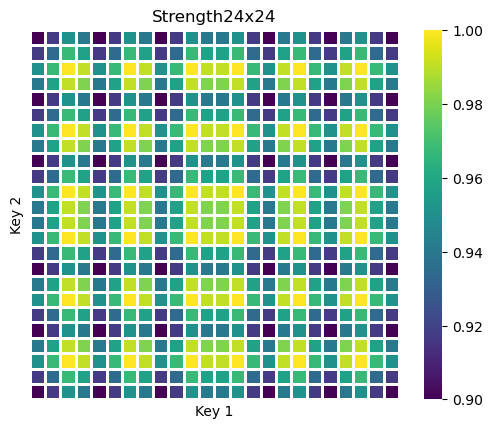

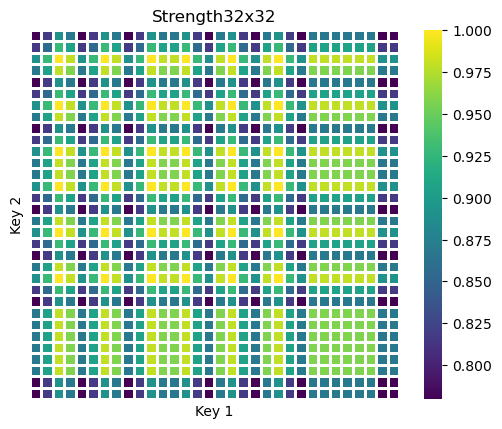

In [7]:
# %load code/load_strength_data.py
# Normalize by the highest peak force (middle finger):
middle_force = 2.36
index_force = 2.26
ring_force = 2.02
little_force = 1.84
middle_norm = 1.0
index_norm = index_force / middle_force
ring_norm = ring_force / middle_force
little_norm = little_force / middle_force
print('index/middle: {0}'.format(index_norm))
print('ring/middle: {0}'.format(ring_norm))
print('little/middle: {0}'.format(little_norm))

# Relative left/right hand strength (assume equal):
lf = 1.0
rf = 1.0

strengths24 = np.array((
                    lf * little_norm, lf * ring_norm, lf * middle_norm, lf * index_norm,
                    lf * little_norm, lf * ring_norm, lf * middle_norm, lf * index_norm,
                    lf * little_norm, lf * ring_norm, lf * middle_norm, lf * index_norm,
                    rf * index_norm, rf * middle_norm, rf * ring_norm, rf * little_norm,
                    rf * index_norm, rf * middle_norm, rf * ring_norm, rf * little_norm,
                    rf * index_norm, rf * middle_norm, rf * ring_norm, rf * little_norm))

# Create a finger-pair position strength matrix by adding pairs of strength values:
Strength24x24 = np.zeros((24, 24))
for i in range(24):
    Strength24x24[i,:] = strengths24
Strength24x24 = (Strength24x24 + Strength24x24.transpose())

# Normalize matrix with min-max scaling to a range with maximum = 1:
#newMin = strength_factor
newMin = min_strength_factor  # np.min(Strength24x24) / np.max(Strength24x24)
newMax = 1.0
Strength24x24 = newMin + (Strength24x24 - np.min(Strength24x24)) * (newMax - newMin) / (np.max(Strength24x24) - np.min(Strength24x24))

# Print:
print_matrix_info(matrix_data=Strength24x24, matrix_label="Strength24x24", nkeys=24, nlines=10)
heatmap(data=Strength24x24, title="Strength24x24", xlabel="Key 1", ylabel="Key 2", print_output=print_output)

# Save:
if print_output:
    file = open("Strength24x24.txt", "w+")
    file.write(str(Strength24x24))
    file.close()


penalty = 1.0  # Penalty for lateral (index, little) finger placement (1 = no penalty)

strengths32 = np.array((lf * little_norm, lf * ring_norm, lf * middle_norm, lf * index_norm,
                        lf * little_norm, lf * ring_norm, lf * middle_norm, lf * index_norm,
                        lf * little_norm, lf * ring_norm, lf * middle_norm, lf * index_norm,
                        rf * index_norm, rf * middle_norm, rf * ring_norm, rf * little_norm,
                        rf * index_norm, rf * middle_norm, rf * ring_norm, rf * little_norm,
                        rf * index_norm, rf * middle_norm, rf * ring_norm, rf * little_norm,
                        lf * index_norm * penalty, lf * index_norm * penalty, lf * index_norm * penalty,
                        rf * index_norm * penalty, rf * index_norm * penalty, rf * index_norm * penalty,
                        rf * little_norm * penalty, rf * little_norm * penalty))

# Create a finger-pair position strength matrix by adding pairs of strength values:
Strength32x32 = np.zeros((32, 32))
for i in range(32):
    Strength32x32[i,:] = strengths32
Strength32x32 = (Strength32x32 + Strength32x32.transpose())

# Normalize matrix with min-max scaling to a range with maximum = 1:
newMin = np.min(Strength32x32) / np.max(Strength32x32)
newMax = 1.0
Strength32x32 = newMin + (Strength32x32 - np.min(Strength32x32)) * (newMax - newMin) / (np.max(Strength32x32) - np.min(Strength32x32))

# Print:
print_matrix_info(matrix_data=Strength32x32, matrix_label="Strength32x32", nkeys=32, nlines=10)
heatmap(data=Strength32x32, title="Strength32x32", xlabel="Key 1", ylabel="Key 2", print_output=print_output)

# Save:
if print_output:
    file = open("Strength32x32.txt", "w+")
    file.write(str(Strength32x32))
    file.close()

## Flow matrix and Engram scoring model  <a name="flow">

The Flow24x24 matrix takes into account ease of transition between ordered pairs of keys.
    
Our optimization algorithm finds every permutation of a given set of letters, maps these letter permutations to a set of keys, and ranks these letter-key mappings according to a score reflecting ease of typing key pairs and frequency of letter pairs (bigrams). The score is the average of the scores for all possible bigrams in this arrangement. The score for each bigram is a product of the frequency of occurrence of that bigram, the frequency of each of the bigram’s characters, and flow, strength (and optional speed) factors for the key pair.

#### Dvorak et al. (1936) defined eleven criteria for the design and evaluation of keyboard layouts:
1.  Deviation from the balance of hand and finger loads should be as low as possible.
2.  Percentage of tapping with the same fingers should be as low as possible.
3.  Percentage of tapping that includes top row should be as low as possible.
4.  Percentage of tapping that includes bottom row should be as low as possible.
5.  Percentage of tapping in the home row should be as high as possible.
6.  Percentage of tapping by alternating hands should be as high as possible.
7.  Percentage of hurdles with the same finger should be as low as possible.
8.  Percentage of hurdles with adjacent offset fingers should be as low as possible.
9.  Percentage of hurdles with remote fingers should be as low as possible.
10. Percentage of reach with the same finger should be as low as possible.
11. Percentage of reach with adjacent offset fingers should be as low as possible.

#### Synopsis of above criteria for pairwise key presses when touch typing:
1. Alternate between hands.
2. Balance finger loads, and avoid using the same finger.
3. Avoid the upper and lower rows, and avoid skipping over the home row.
4. Avoid tapping adjacent offset rows with the same or adjacent offset fingers.
    
### Factors to penalize strenuous key transitions

Direction:
    
    - outward = 0.9: outward roll of fingers from the index to little finger (same hand)

Dexterity:
    
    - side_above_3away = 0.9
        - index and little finger type two keys, one or more rows apart (same hand)
    - side_above_2away = 0.9^2 = 0.81
        - index finger types key a row or two above ring finger key, or
        - little finger types key a row or two above middle finger key (same hand)
    - side_above_1away = 0.9^3 = 0.729
        - index finger types key a row or two above middle finger key, or
        - little finger types key a row or two above ring finger key (same hand)
    - middle_above_ring = 0.9
        - middle finger types key a row or two above ring finger key (same hand)
    - ring_above_middle = 0.9^3 = 0.729
        - ring finger types key a row or two above middle finger key (same hand)
    - lateral = 0.9
        - lateral movement of (index or little) finger outside of 8 vertical columns
    
Distance:
    
    - skip_row_3away = 0.9       
        - index and little fingers type two keys that skip over home row (same hand)
        - (e.g., one on bottom row, the other on top row)
    - skip_row_2away = 0.9^3 = 0.729
        - little and middle or index and ring fingers type two keys that skip over home row (same hand)
    - skip_row_1away = 0.9^5 = 0.59049
        - little and ring or middle and index fingers type two keys that skip over home row (same hand)

Repetition:
 
    - skip_row_0away = 0.9^4 = 0.6561
        - same finger types two keys that skip over home row
    - same_finger = 0.9^5 = 0.59049
        - use same finger again for a different key
        - cannot accompany outward, side_above, or adjacent_shorter_above 

Strength: Accounted for by the strength matrix (minimum value for the little finger = 0.9)    

### Example flow values for left side home block
   
No penalty (for same hand, both keys in the same row in an inward roll or repeating the same key):

    2=>2, 2=>3, 3=>4, 2=>4, 1=>4

    1  2  3  4
    5  6  7  8
    9 10 11 12

Penalty = 0.9:

    outward: 2=>1, 3=>1, 3=>2, 4=>1, 4=>2, 4=>3, 6=>5, 7=>6, 7=>5, 8=>7, 8=>6, 8=>5,... 
    middle_above_ring: 6=>3, 10=>7 
    side_above_3away: 1=>8, 5=>4, 5=>12, 9=>8
    index_above: 1=>4, 2=>4, 3=>4, 4=>4

Penalty = 0.9^2:

    middle_above_ring * outward: 3=>6, 7=>10
    side_above_3away * outward: 8=>1, 4=>5, 12=>5, 8=>9
    side_above_2away: 1=>7, 6=>4, 5=>11, 10=>8    
    skip_row_3away * side_above_3away: 1=>12, 9=>4
    skip_row_2away: 2=>12, 9=>3
    ring_above_middle 2=>7, 6=>11
    side_above_2away * outward: 7=>1, 4=>6, 11=>5, 8=>10
    side_above_1away: 1=>6, 7=>4, 5=>10, 11=>8

Penalty = 0.9^3:

    skip_row_3away * side_above_3away * outward: 12=>1, 4=>9

Penalty = 0.9^4:

    ring_above_middle * outward: 7=>2, 11=>6
    side_above_1away * outward: 4=>7, 6=>1, 10=>5, 4=>7

Penalty = 0.9^5:

    same_finger: 4=>8, 8=>4, 1=>5, 5=>1, 5=>9, 9=>5, 2=>6, 6=>2,...
    skip_row_2away * side_above_2away: 10=>4, 1=>11
    skip_row_1away: 1=>10, 9=>2, 3=>12

Penalty = 0.9^6:

    skip_row_2away * side_above_2away * outward: 4=>10, 11=>1
    skip_row_1away * outward: 10=>1, 2=>9, 12=>3

Penalty = 0.9^8

    skip_row_1away * ring_above_middle: 2=>11
    skip_row_1away * side_above_1away: 1=>10, 11=>4

Penalty = 0.9^9

    skip_row_1away * ring_above_middle * outward: 11=>2
    skip_row_0away * same_finger: 1=>9, 9=>1, 4=>12, 12=>4, 2=>10, 10=>2, 3=>11, 11=>3     
    skip_row_1away * side_above_1away * outward: 10=>1, 4=>11

Flow24x24 min = 0.387420489, max = 1.0
Flow24x24 key number pairs with minimum values:
        2 -> 10        (0.387420489)
        10 -> 1        (0.387420489)
        3 -> 11        (0.387420489)
        10 -> 2        (0.387420489)
        14 -> 22        (0.387420489)
        24 -> 16        (0.387420489)
        15 -> 23        (0.387420489)
        13 -> 21        (0.387420489)
        16 -> 24        (0.387420489)
        21 -> 13        (0.387420489)
        4 -> 11        (0.387420489)
        13 -> 22        (0.387420489)
        1 -> 9        (0.387420489)
        4 -> 12        (0.387420489)
        22 -> 15        (0.387420489)
        22 -> 14        (0.387420489)
        9 -> 1        (0.387420489)
        12 -> 4        (0.387420489)
        11 -> 2        (0.387420489)
        11 -> 3        (0.387420489)
        23 -> 15        (0.387420489)
        23 -> 16        (0.387420489)
        11 -> 4        (0.43046720999999993)
        2 -> 11        (0.43046720999999993)


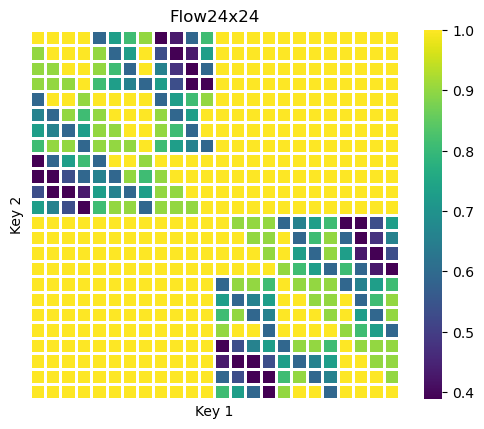

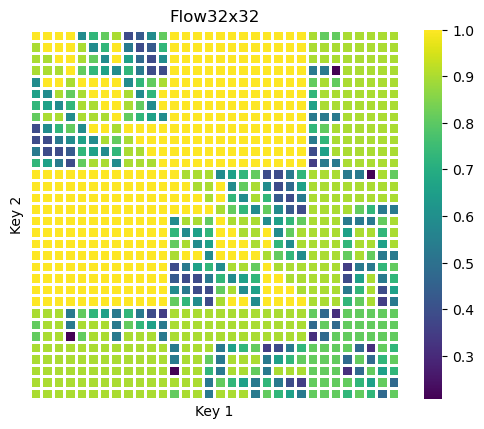

In [8]:
# %load code/load_flow_matrices.py
# Penalizing factors for 24 keys  (1 = no penalty; set to less than 1 to penalize):

# Dexterity
side_above_3away = 0.9     # index and little finger type two keys, one or more rows apart (same hand)
side_above_2away = 0.81    # index finger types key a row or two above ring finger key, or
                           # little finger types key a row or two above middle finger key (same hand)
side_above_1away = 0.729   # index finger types key a row or two above middle finger key, or
                           # little finger types key a row or two above ring finger key (same hand)
middle_above_ring = 0.9    # middle finger types key a row or two above ring finger key (same hand)
ring_above_middle = 0.729  # ring finger types key a row or two above middle finger key (same hand)
lateral = 0.9              # lateral movement of (index or little) finger outside of 8 vertical columns

# Direction
outward = 0.9              # outward roll of fingers from the index to little finger (same hand)

# Distance
skip_row_3away = 0.9       # index and little fingers type two keys that skip over home row (same hand)
                           # (e.g., one on bottom row, the other on top row)
skip_row_2away = 0.729     # little and middle or index and ring fingers type two keys that skip over home row (same hand)
skip_row_1away = 0.59049   # little and ring or middle and index fingers type two keys that skip over home row (same hand)

# Repetition
skip_row_0away = 0.6561    # same finger types two keys that skip over home row
same_finger = 0.59049      # use same finger again for a different key


# Unused or redundant parameters
same_hand = 1.0            # (addressed by splitting up the most frequent letters across left/right sides above)
not_home_row = 1.0         # at least one key not on home row
side_top = 1.0             # index or little finger types top corner key
shorter_above = 1.0        # (taken care of by side_above_[1,2,3]away parameters)
adjacent_offset = 1.0      # (taken care of by side_above_1away, middle_above_ring, ring_above_middle parameters)
inside_top = 1.0           # index finger types top corner key (taken care of by side_above_1away parameter)
index_above = 1.0          # index finger types top corner key (unless other bigram key is in the top row for the same hand)
                           # (taken care of by side_above_[1,2,3]away parameters)


def create_24x24_flow_matrix(not_home_row, side_top, side_above_3away, side_above_2away, side_above_1away, 
                             middle_above_ring, ring_above_middle, outward, skip_row_3away, 
                             skip_row_2away, skip_row_1away, skip_row_0away, same_finger, lateral, 
                             same_hand, shorter_above, adjacent_offset, inside_top, index_above):

    all_24_keys = [1,2,3,4, 5,6,7,8, 9,10,11,12, 13,14,15,16, 17,18,19,20, 21,22,23,24]

    # Create a matrix and multiply by flow factors that promote easy interkey transitions:
    T = np.ones((24, 24))

    # 7.  Promote alternating between hands over uncomfortable transitions with the same hand.
    if same_hand < 1.0:
    #    1  2  3  4   13 14 15 16  
    #    5  6  7  8   17 18 19 20 
    #    9 10 11 12   21 22 23 24
        for i in range(0,12):
            for j in range(0,12):
                T[i,j] *= same_hand
        for i in range(12,24):
            for j in range(12,24):
                T[i,j] *= same_hand

    # 8.  Promote little-to-index-finger roll-ins over index-to-little-finger outwards.
    #    1  2  3  4   13 14 15 16  
    #    5  6  7  8   17 18 19 20 
    #    9 10 11 12   21 22 23 24
    if outward < 1.0:

        # same-row roll-outs:
        roll_ins = [[1,2],[2,3],[3,4], [5,6],[6,7],[7,8], [9,10],[10,11],[11,12],
                    [16,15],[15,14],[14,13], [20,19],[19,18],[18,17], [24,23],[23,22],[22,21]]
        for x in roll_ins:
            T[x[1]-1, x[0]-1] *= outward

        # same-row roll-outs, skipping keys:
        roll_ins_skip_keys = [[1,3],[2,4],[1,4], [5,7],[6,8],[5,8], [9,11],[10,12],[9,12],
                              [16,14],[15,13],[16,13], [20,18],[19,17],[20,17], [24,22],[23,21],[24,21]]
        for x in roll_ins_skip_keys:
            T[x[1]-1, x[0]-1] *= outward

        # adjacent-row roll-outs:
        roll_ins_adj_rows = [[1,6],[1,7],[1,8],[2,7],[2,8],[3,8], [5,2],[5,3],[5,4],[6,3],[6,4],[7,4],
                             [5,10],[5,11],[5,12],[6,11],[6,12],[7,12], [9,6],[9,7],[9,8],[10,7],[10,8],[11,8],
                             [16,19],[16,18],[16,17],[15,18],[15,17],[14,17], [20,15],[20,14],[20,13],[19,14],[19,13],[18,13],
                             [20,23],[20,22],[20,21],[19,22],[19,21],[18,21], [24,19],[24,18],[24,17],[23,18],[23,17],[22,17]]
        for x in roll_ins_adj_rows:
            T[x[1]-1, x[0]-1] *= outward

        # upper<->lower row roll-outs:
        roll_ins_skip_home = [[1,10],[1,11],[1,12],[2,11],[2,12],[3,12], [9,2],[9,3],[9,4],[10,3],[10,4],[11,4],
                              [16,23],[16,22],[16,21],[15,22],[15,21],[14,21], [24,15],[24,14],[24,13],[23,14],[23,13],[22,13]]
        for x in roll_ins_skip_home:
            T[x[1]-1, x[0]-1] *= outward

    # 9.  Avoid stretching shorter fingers up and longer fingers down.
    #    1  2  3  4   13 14 15 16  
    #    5  6  7  8   17 18 19 20 
    #    9 10 11 12   21 22 23 24
    if index_above < 1.0:
        for x in [4]:
            for y in [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]:
                T[x-1, y-1] *= index_above
                T[y-1, x-1] *= index_above
        for x in [13]:
            for y in [1,2,3,4,5,6,7,8,9,10,11,12,13,17,18,19,20,21,22,23,24]:
                T[x-1, y-1] *= index_above
                T[y-1, x-1] *= index_above
    if inside_top < 1.0:
        for x in [4,13]:
            for j in range(0,24):
                T[x-1, j] *= inside_top
                T[j, x-1] *= inside_top
    if side_top < 1.0:
        for x in [1,4,13,16]:
            for j in range(0,24):
                T[x-1, j] *= side_top
                T[j, x-1] *= side_top
    if side_above_1away < 1.0:
        for x in [1]:
            for y in [6,10]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [5]:
            for y in [10]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [4]:
            for y in [7,11]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [8]:
            for y in [11]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [13]:
            for y in [18,22]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [17]:
            for y in [22]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [16]:
            for y in [19,23]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [20]:
            for y in [23]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
    if side_above_2away < 1.0:
        for x in [1]:
            for y in [7,11]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [5]:
            for y in [11]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [4]:
            for y in [6,10]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [8]:
            for y in [10]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [13]:
            for y in [19,23]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [17]:
            for y in [23]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [16]:
            for y in [18,22]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [20]:
            for y in [22]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
    if side_above_3away < 1.0:
        for x in [1]:
            for y in [8,12]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [5]:
            for y in [12]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [4]:
            for y in [5,9]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [8]:
            for y in [9]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [13]:
            for y in [20,24]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [17]:
            for y in [24]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [16]:
            for y in [17,21]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [20]:
            for y in [21]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
    if shorter_above < 1.0:
        for x in [1]:
            for y in [6,7,8,10,11,12]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [2]:
            for y in [7,11]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [4]:
            for y in [6,7,10,11]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above

        for x in [5]:
            for y in [10,11,12]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [6]:
            for y in [11]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [8]:
            for y in [10,11]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above

        for x in [16]:
            for y in [17,18,19,21,22,23]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [15]:
            for y in [18,22]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [13]:
            for y in [18,19,22,23]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above

        for x in [20]:
            for y in [21,22,23]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [19]:
            for y in [22]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [17]:
            for y in [22,23]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above

    if ring_above_middle < 1.0:
        ring_above_middles =  [[2,7],[6,11],[2,11],
                            [15,18],[19,22],[15,22]]
        for x in ring_above_middles:
            T[x[0]-1, x[1]-1] *= ring_above_middle
            T[x[1]-1, x[0]-1] *= ring_above_middle

    if middle_above_ring < 1.0:
        middle_above_rings =  [[6,3],[10,7],[10,3],
                            [19,14],[23,18],[23,14]]
        for x in middle_above_rings:
            T[x[0]-1, x[1]-1] *= middle_above_ring
            T[x[1]-1, x[0]-1] *= middle_above_ring

    # 10. Avoid using the same finger.
    #    1  2  3  4   13 14 15 16  
    #    5  6  7  8   17 18 19 20 
    #    9 10 11 12   21 22 23 24
    if same_finger < 1.0:
        same_fingers = [[1,5],[5,9],[1,9], [2,6],[6,10],[2,10], [3,7],[7,11],[3,11], [4,8],[8,12],[4,12],
                        [13,17],[17,21],[13,21], [14,18],[18,22],[14,22], [15,19],[19,23],[15,23], [16,20],[20,24],[16,24]] 
        for x in same_fingers:
            T[x[0]-1, x[1]-1] *= same_finger
            T[x[1]-1, x[0]-1] *= same_finger

    # 11. Avoid the upper and lower rows.
    #    1  2  3  4   13 14 15 16  
    #    5  6  7  8   17 18 19 20 
    #    9 10 11 12   21 22 23 24
    if not_home_row < 1.0:
        not_home_row_keys = [1,2,3,4, 9,10,11,12, 13,14,15,16, 21,22,23,24]
        for x in not_home_row_keys:
            for j in range(0,23):
                T[x-1, j] *= not_home_row
                T[j, x-1] *= not_home_row

    # 12. Avoid skipping over the home row.
    #    1  2  3  4   13 14 15 16  
    #    5  6  7  8   17 18 19 20 
    #    9 10 11 12   21 22 23 24
    if skip_row_0away < 1.0:
        skip_top = [1, 2, 3, 4, 13,14,15,16] 
        skip_bot = [9,10,11,12, 21,22,23,24] 
        for ix, x in enumerate(skip_top):
            y = skip_bot[ix]
            T[x-1, y-1] *= skip_row_0away
            T[y-1, x-1] *= skip_row_0away
    if skip_row_1away < 1.0:
        skip_top = [1, 2, 2, 3, 3, 4, 13,14,14,15,15,16] 
        skip_bot = [10,9,11,10,12,11, 22,21,23,22,24,23] 
        for ix, x in enumerate(skip_top):
            y = skip_bot[ix]
            T[x-1, y-1] *= skip_row_1away
            T[y-1, x-1] *= skip_row_1away
    if skip_row_2away < 1.0:
        skip_top = [1,  2,3, 4, 13,14,15,16] 
        skip_bot = [11,12,9,10, 23,24,21,22] 
        for ix, x in enumerate(skip_top):
            y = skip_bot[ix]
            T[x-1, y-1] *= skip_row_2away
            T[y-1, x-1] *= skip_row_2away
    if skip_row_3away < 1.0:
        skip_top = [1, 4, 13,16] 
        skip_bot = [12,9, 24,21] 
        for ix, x in enumerate(skip_top):
            y = skip_bot[ix]
            T[x-1, y-1] *= skip_row_3away
            T[y-1, x-1] *= skip_row_3away

    Flow24x24 = T

    # Normalize matrix with min-max scaling to a range with maximum = 1:
    newMin = np.min(Flow24x24) / np.max(Flow24x24)
    newMax = 1.0
    Flow24x24 = newMin + (Flow24x24 - np.min(Flow24x24)) * (newMax - newMin) / (np.max(Flow24x24) - np.min(Flow24x24))

    return Flow24x24

Flow24x24 = create_24x24_flow_matrix(not_home_row, side_top, 
    side_above_3away, side_above_2away, side_above_1away, middle_above_ring, ring_above_middle, outward, 
    skip_row_3away, skip_row_2away, skip_row_1away, skip_row_0away, same_finger, lateral, same_hand, 
    shorter_above, adjacent_offset, inside_top, index_above)

# Print:
print_matrix_info(matrix_data=Flow24x24, matrix_label="Flow24x24", nkeys=24, nlines=30)
heatmap(data=Flow24x24, title="Flow24x24", xlabel="Key 1", ylabel="Key 2", print_output=print_output)


def create_32x32_flow_matrix(not_home_row, side_top, side_above_3away, side_above_2away, side_above_1away, 
                             middle_above_ring, ring_above_middle, outward, skip_row_3away, 
                             skip_row_2away, skip_row_1away, skip_row_0away, same_finger, lateral, 
                             same_hand, shorter_above, adjacent_offset, inside_top, index_above):

    all_32_keys = [1,2,3,4, 5,6,7,8, 9,10,11,12, 13,14,15,16, 17,18,19,20, 21,22,23,24, 
                   25,26,27, 28,29,30, 31,32]

    # Create a matrix and multiply by flow factors that promote easy interkey transitions:
    T = np.ones((32, 32))

    if lateral < 1.0:
        for x in all_32_keys:
            for y in [25,26,27, 28,29,30, 31,32]:
                T[x-1, y-1] *= lateral
                T[y-1, x-1] *= lateral    

    # 7.  Promote alternating between hands over uncomfortable transitions with the same hand.
    if same_hand < 1.0:
        for i in [1,2,3,4,5,6,7,8,9,10,11,12, 25,26,27]:
            for j in [1,2,3,4,5,6,7,8,9,10,11,12, 25,26,27]:
                T[i-1,j-1] *= same_hand
        for i in [13,14,15,16,17,18,19,20,21,22,23,24, 28,29,30,31,32]:
            for j in [13,14,15,16,17,18,19,20,21,22,23,24, 28,29,30,31,32]:
                T[i-1,j-1] *= same_hand

    # 8.  Promote little-to-index-finger roll-ins over index-to-little-finger outsward rolls.
    # Penalize (index, little) finger lateral movements:
    #  1  2  3  4 25   28 13 14 15 16 31 
    #  5  6  7  8 26   29 17 18 19 20 32
    #  9 10 11 12 27   30 21 22 23 24
    if outward < 1.0:

        # same-row roll-outs:
        roll_ins = [[1,2],[2,3],[3,4], [5,6],[6,7],[7,8], [9,10],[10,11],[11,12],
                    [16,15],[15,14],[14,13], [20,19],[19,18],[18,17], [24,23],[23,22],[22,21]]
        for x in roll_ins:
            T[x[1]-1, x[0]-1] *= outward

        # same-row roll-outs, skipping keys:
        roll_ins_skip_keys = [[1,3],[2,4],[1,4], [5,7],[6,8],[5,8], [9,11],[10,12],[9,12],
                              [16,14],[15,13],[16,13], [20,18],[19,17],[20,17], [24,22],[23,21],[24,21]]
                              #[1,25],[2,25],[3,25],
                              #[5,26],[6,26],[7,26],
                              #[9,27],[10,27],[11,27],
                              #[16,28],[15,28],[14,28],
                              #[20,29],[19,29],[18,29],
                              #[24,30],[23,30],[22,30],
                              #[31,15],[31,14],[31,13],[31,28],
                              #[32,19],[32,18],[32,17],[32,29]]
        for x in roll_ins_skip_keys:
            T[x[1]-1, x[0]-1] *= outward

        # adjacent-row roll-outs:
        #  1  2  3  4 25   28 13 14 15 16 31 
        #  5  6  7  8 26   29 17 18 19 20 32
        #  9 10 11 12 27   30 21 22 23 24
        roll_ins_adj_rows = [[1,6],[1,7],[1,8],[2,7],[2,8],[3,8], 
                             [5,2],[5,3],[5,4],[6,3],[6,4],[7,4],
                             [5,10],[5,11],[5,12],[6,11],[6,12],[7,12], 
                             [9,6],[9,7],[9,8],[10,7],[10,8],[11,8],
                             [16,19],[16,18],[16,17],[15,18],[15,17],[14,17], 
                             [20,15],[20,14],[20,13],[19,14],[19,13],[18,13],
                             [20,23],[20,22],[20,21],[19,22],[19,21],[18,21], 
                             [24,19],[24,18],[24,17],[23,18],[23,17],[22,17]]
                             #[5,25],[6,25],[7,25],[8,25],
                             #[5,27],[6,27],[7,27],[8,27],
                             #[1,26],[2,26],[3,26],[4,26],
                             #[9,26],[10,26],[11,26],[12,26],
                             #[16,29],[15,29],[14,29],[13,29],
                             #[24,29],[23,29],[22,29],[21,29],
                             #[20,28],[19,28],[18,28],[17,28],
                             #[20,30],[19,30],[18,30],[17,30],
                             #[31,20],[31,19],[31,18],[31,17],[31,29],
                             #[32,16],[32,15],[32,14],[32,13],[32,28],
                             #[32,24],[32,23],[32,22],[32,21],[32,30]]
        for x in roll_ins_adj_rows:
            T[x[1]-1, x[0]-1] *= outward

        # upper<->lower row roll-outs:
        roll_ins_skip_home = [[1,10],[1,11],[1,12],[2,11],[2,12],[3,12],
                              [9,2],[9,3],[9,4],[10,3],[10,4],[11,4],
                              [16,23],[16,22],[16,21],[15,22],[15,21],[14,21],
                              [24,15],[24,14],[24,13],[23,14],[23,13],[22,13]]
                              #[16,30],[15,30],[14,30],[13,30],
                              #[9,25],[10,25],[11,25],[12,25],
                              #[24,28],[23,28],[22,28],[21,28],
                              #[1,27],[2,27],[3,27],[4,27], 
                              #[31,24],[31,23],[31,22],[31,21],[31,30]]
        for x in roll_ins_skip_home:
            T[x[1]-1, x[0]-1] *= outward

    # 9.  Avoid stretching shorter fingers up and longer fingers down.
    #  1  2  3  4 25   28 13 14 15 16 31 
    #  5  6  7  8 26   29 17 18 19 20 32
    #  9 10 11 12 27   30 21 22 23 24
    if index_above < 1.0:
        for x in [4]:
            for y in [4,5,6,7,8,26,9,10,11,12,27,28,13,14,15,16,31,29,17,18,19,20,32,30,21,22,23,24]:
                T[x-1, y-1] *= index_above
                T[y-1, x-1] *= index_above
        for x in [25]:
            for y in [25,5,6,7,8,26,9,10,11,12,27,28,13,14,15,16,31,29,17,18,19,20,32,30,21,22,23,24]:
                T[x-1, y-1] *= index_above
                T[y-1, x-1] *= index_above
        for x in [13]:
            for y in [1,2,3,4,25,5,6,7,8,26,9,10,11,12,27,13,29,17,18,19,20,32,30,21,22,23,24]:
                T[x-1, y-1] *= index_above
                T[y-1, x-1] *= index_above
        for x in [28]:
            for y in [1,2,3,4,25,5,6,7,8,26,9,10,11,12,27,28,29,17,18,19,20,32,30,21,22,23,24]:
                T[x-1, y-1] *= index_above
                T[y-1, x-1] *= index_above
    if inside_top < 1.0:
        for x in [4,25,28,13]:
            for j in range(0,32):
                T[x-1, j] *= inside_top
                T[j, x-1] *= inside_top
    if side_top < 1.0:
        for x in [1,4,25,28,13,16,31]:
            for j in range(0,32):
                T[x-1, j] *= side_top
                T[j, x-1] *= side_top
    if side_above_1away < 1.0:
        for x in [1]:
            for y in [6,10]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [5]:
            for y in [10]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [4,25]:
            for y in [7,11]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [8,26]:
            for y in [11]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [13,28]:
            for y in [18,22]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [17,29]:
            for y in [22]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [16,31]:
            for y in [19,23]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
        for x in [20,32]:
            for y in [23]:
                T[x-1, y-1] *= side_above_1away
                T[y-1, x-1] *= side_above_1away
    if side_above_2away < 1.0:
        for x in [1]:
            for y in [7,11]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [5]:
            for y in [11]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [4,25]:
            for y in [6,10]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [8,26]:
            for y in [10]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [13,28]:
            for y in [19,23]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [17,29]:
            for y in [23]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [16,31]:
            for y in [18,22]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
        for x in [20,32]:
            for y in [22]:
                T[x-1, y-1] *= side_above_2away
                T[y-1, x-1] *= side_above_2away
    if side_above_3away < 1.0:
        for x in [1]:
            for y in [8,12,26,27]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [5]:
            for y in [12,27]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [4,25]:
            for y in [5,9]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [8,26]:
            for y in [9]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [13,28]:
            for y in [20,24,32]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [17,29]:
            for y in [24]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [16,31]:
            for y in [17,21,29,30]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away
        for x in [20,32]:
            for y in [21,30]:
                T[x-1, y-1] *= side_above_3away
                T[y-1, x-1] *= side_above_3away


    #  1  2  3  4 25   28 13 14 15 16 31 
    #  5  6  7  8 26   29 17 18 19 20 32
    #  9 10 11 12 27   30 21 22 23 24
    if shorter_above < 1.0:
        for x in [1]:
            for y in [6,7,8,26,10,11,12,27]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [2]:
            for y in [7,11]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [4]:
            for y in [6,7,10,11]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [25]:
            for y in [6,7,10,11]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above

        for x in [5]:
            for y in [10,11,12,27]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [6]:
            for y in [11]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [8]:
            for y in [10,11]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [26]:
            for y in [10,11]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above

        for x in [16]:
            for y in [29,17,18,19,30,21,22,23]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [31]:
            for y in [29,17,18,19,30,21,22,23]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [15]:
            for y in [18,22]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [13]:
            for y in [18,19,22,23]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [28]:
            for y in [18,19,22,23]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above

        for x in [20]:
            for y in [30,21,22,23]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [32]:
            for y in [30,21,22,23]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [19]:
            for y in [22]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [17]:
            for y in [22,23]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above
        for x in [29]:
            for y in [22,23]:
                T[x-1, y-1] *= shorter_above
                T[y-1, x-1] *= shorter_above

    if ring_above_middle < 1.0:
        ring_above_middles =  [[2,7],[6,11],[2,11],
                            [15,18],[19,22],[15,22]]
        for x in ring_above_middles:
            T[x[0]-1, x[1]-1] *= ring_above_middle
            T[x[1]-1, x[0]-1] *= ring_above_middle

    if middle_above_ring < 1.0:
        middle_above_rings =  [[6,3],[10,7],[10,3],
                            [19,14],[23,18],[23,14]]
        for x in middle_above_rings:
            T[x[0]-1, x[1]-1] *= middle_above_ring
            T[x[1]-1, x[0]-1] *= middle_above_ring

    # 10. Avoid using the same finger.
    #  1  2  3  4 25   28 13 14 15 16 31 
    #  5  6  7  8 26   29 17 18 19 20 32
    #  9 10 11 12 27   30 21 22 23 24
    if same_finger < 1.0:
        same_fingers = [[1,5],[5,9],[1,9], [2,6],[6,10],[2,10], 
                        [3,7],[7,11],[3,11], [4,8],[8,12],[4,12],
                        [25,26],[26,27],[25,27], [28,29],[29,30],[28,30], [31,32],
                        [4,25],[4,26],[4,27], [8,25],[8,26],[8,27], [12,25],[12,26],[12,27],
                        [13,28],[13,29],[13,30], [17,28],[17,29],[17,30], [21,28],[21,29],[21,30],
                        [31,16],[31,20],[31,24], [32,16],[32,20],[32,24],
                        [13,17],[17,21],[13,21], [14,18],[18,22],[14,22], 
                        [15,19],[19,23],[15,23], [16,20],[20,24],[16,24]] 
        for x in same_fingers:
            T[x[0]-1, x[1]-1] *= same_finger
            T[x[1]-1, x[0]-1] *= same_finger

    # 11. Avoid the upper and lower rows.
    if not_home_row < 1.0:
        not_home_row_keys = [1,2,3,4,25, 9,10,11,12,27, 28,13,14,15,16,31, 30,21,22,23,24]
        for x in not_home_row_keys:
            for j in range(0,32):
                T[x-1, j] *= not_home_row
                T[j, x-1] *= not_home_row
                
    # 12. Avoid skipping over the home row.
    #  1  2  3  4 25   28 13 14 15 16 31 
    #  5  6  7  8 26   29 17 18 19 20 32
    #  9 10 11 12 27   30 21 22 23 24
    if skip_row_0away < 1.0:
        skip_top = [1, 2, 3, 4, 4,25,25, 28,28,13,13,14,15,16,31] 
        skip_bot = [9,10,11,12,27,12,27, 30,21,30,21,22,23,24,24] 
        for ix, x in enumerate(skip_top):
            y = skip_bot[ix]
            T[x-1, y-1] *= skip_row_0away
            T[y-1, x-1] *= skip_row_0away
    if skip_row_1away < 1.0:
        skip_top = [1, 2, 2, 3, 3, 4, 4,25, 28,13,13,14,14,15,15,16,31] 
        skip_bot = [10,9,11,10,12,11,27,11, 22,30,22,21,23,22,24,23,23] 
        for ix, x in enumerate(skip_top):
            y = skip_bot[ix]
            T[x-1, y-1] *= skip_row_1away
            T[y-1, x-1] *= skip_row_1away
    if skip_row_2away < 1.0:
        skip_top = [1,  2,3, 4,25, 28,13,14,15,16,31] 
        skip_bot = [11,12,9,10,10, 23,23,24,21,22,22] 
        for ix, x in enumerate(skip_top):
            y = skip_bot[ix]
            T[x-1, y-1] *= skip_row_2away
            T[y-1, x-1] *= skip_row_2away
    if skip_row_3away < 1.0:
        skip_top = [1, 4,25, 28,13,16,16,31,31] 
        skip_bot = [12,9, 9, 24,24,21,30,21,30] 
        for ix, x in enumerate(skip_top):
            y = skip_bot[ix]
            T[x-1, y-1] *= skip_row_3away
            T[y-1, x-1] *= skip_row_3away
                
    Flow32x32 = T

    # Normalize matrix with min-max scaling to a range with maximum = 1:
    newMin = np.min(Flow32x32) / np.max(Flow32x32)
    newMax = 1.0
    Flow32x32 = newMin + (Flow32x32 - np.min(Flow32x32)) * (newMax - newMin) / (np.max(Flow32x32) - np.min(Flow32x32))

    return Flow32x32

Flow32x32 = create_32x32_flow_matrix(not_home_row, side_top, 
    side_above_3away, side_above_2away, side_above_1away, middle_above_ring, ring_above_middle, outward, 
    skip_row_3away, skip_row_2away, skip_row_1away, skip_row_0away, same_finger, lateral, same_hand, 
    shorter_above, adjacent_offset, inside_top, index_above)

# Print:
print_matrix_info(matrix_data=Flow32x32, matrix_label="Flow32x32", nkeys=32, nlines=30)
heatmap(data=Flow32x32, title="Flow32x32", xlabel="Key 1", ylabel="Key 2", print_output=print_output)


## Combine Strength and Flow matrices  <a name="strengthflow">

Factors24x24 min = 0.3486784401, max = 1.0
Factors24x24 key number pairs with minimum values:
        9 -> 1        (0.3486784401)
        1 -> 9        (0.3486784401)
        24 -> 16        (0.3486784401)
        16 -> 24        (0.3486784401)
        10 -> 1        (0.3553837947173077)
        23 -> 16        (0.3553837947173077)
        2 -> 10        (0.3620891493346154)
        23 -> 15        (0.3620891493346154)
        15 -> 23        (0.3620891493346154)
        10 -> 2        (0.3620891493346154)
        22 -> 15        (0.3747548191673077)
        11 -> 2        (0.3747548191673077)
        21 -> 13        (0.37997009498076917)
        12 -> 4        (0.37997009498076917)
        13 -> 21        (0.37997009498076917)
        4 -> 12        (0.37997009498076917)
        13 -> 22        (0.3836952919903846)
        4 -> 11        (0.3836952919903846)
        22 -> 14        (0.387420489)
        14 -> 22        (0.387420489)
        11 -> 3        (0.387420489)
        3 -> 1

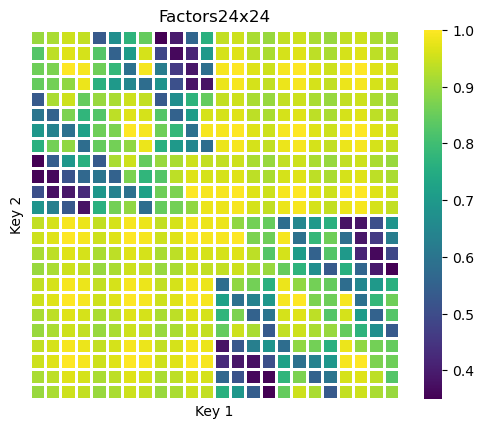

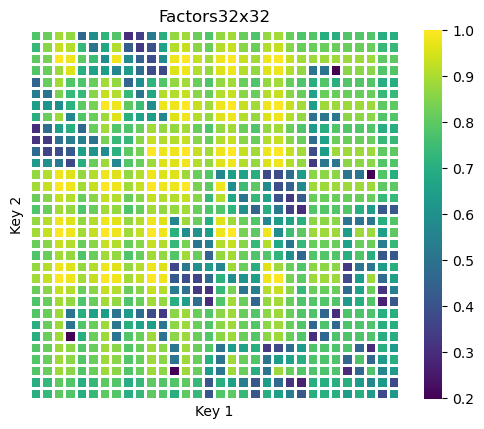

In [9]:
# %load code/combine_scoring_matrices.py
# 24 keys:
Factors24x24 = Flow24x24
if apply_strength:
    Factors24x24 = Strength24x24 * Factors24x24

# Print:
print_matrix_info(matrix_data=Factors24x24, matrix_label="Factors24x24", nkeys=24, nlines=30)
heatmap(data=Factors24x24, title="Factors24x24", xlabel="Key 1", ylabel="Key 2", print_output=print_output)

# Save:
if print_output:
    file = open("Factors24x24.txt", "w+")
    file.write(str(Factors24x24))
    file.close()


# 32 keys:
Factors32x32 = Flow32x32
if apply_strength:
    Factors32x32 = Strength32x32 * Factors32x32

# Print:
print_matrix_info(matrix_data=Factors32x32, matrix_label="Factors32x32", nkeys=32, nlines=30)
heatmap(data=Factors32x32, title="Factors32x32", xlabel="Key 1", ylabel="Key 2", print_output=print_output)

# Save:
if print_output:
    file = open("Factors32x32.txt", "w+")
    file.write(str(Factors32x32))
    file.close()

## Four steps

We will assign letters to keys by choosing the arrangement with the highest score according to our scoring model. However, there are over four hundred septillion, or four hundred trillion trillion (26! = 403,291,461,126,605,635,584,000,000, or 4.032914611 E+26) possible arrangements of 26 letters (24! = 6.204484017 E+23), so we will arrange the letters in four steps, based on ergonomics principles. These consist of (Step 1) assigning the eight most frequent letters to different keys, optimizing assignment of the remaining (Step 2) eight most frequent letters, and (Step 3) eight least frequent letters (besides Z and Q), and (Step 4) exchanging letters. 

## Step 1: Define the shape of the key layout to minimize lateral finger movements<a name="step1">

We will assign 24 letters to 8 columns of keys separated by two middle columns reserved for punctuation. These 8 columns require no lateral finger movements when touch typing, since there is one column per finger. The most comfortable keys include the left and right home rows (keys 5-8 and 17-20), the top-center keys (2,3 and 14,15) that allow the longer middle and ring fingers to uncurl upwards, as well as the bottom corner keys (9,12 and 21,24) that allow the shorter fingers to curl downwards. We will assign the two least frequent letters, W and K, to the two hardest-to-reach keys lying outside the 24-key columns in the upper right (25 and 26):

        Left:            Right:
     1  2  3  4       13 14 15 16 25
     5  6  7  8       17 18 19 20 26
     9 10 11 12       21 22 23 24

We will consider the most comfortable keys to be those typed by either hand on the home row, by the ring and middle finger above the home row, and by the index and little finger below the home row, with a preference for the strongest (index and middle) fingers:
    
     -  2  3  -        - 14 15  -  
     5  6  7  8       17 18 19 20  
     9  -  - 12       21  -  - 24

## Step 2: Arrange the most frequent letters based on comfort and bigram frequencies  <a name="step2">

Below, we will arrange vowels on one side and the most frequent consonants to the other side to encourage balance and alternation across hands. Since aside from the letters W and K there is symmetry across left and right sides, we will decide later which side the vowels and which side the most frequent consonants should go.

### Vowels
    
**E, A, O**, S, N, **I**, R, L, D, C, T, U, M, P, B, G, V, Q, Y, F, H, J, Z, X, K, W
                         
Bigrams that contain two non-repeating vowels, and their frequencies:
  
    UE	17135545
    IO	10629390
    IA	 9704625
    IE 	 8264649
    UA	 2727622
    UI	 2699510
    EA   1634965
    AU   1206620
    EO	  787382
    AI	  768894
    EI	  578063
    EU	  338775
    IU	  314965
    AE	  279633
    OI	  193436
    OE	  182266
    UO	  175574
    OU	  174475
    OA	  117839
    AO	   88065
  
We will assign the most frequent vowels (E=294897235, A=271738665, O=201996963, I=151438547) to four of the six most comfortable keys on the left side of the keyboard (keys 2,3,5,6,7,8). We will assign the letter E, the most frequent in the Spanish language, to the strongest (middle) finger on the home row, and assign the other three vowels such that (1) the home row keys typed by the index and middle fingers are not left vacant, and any top-frequency bigram (more than 1 million instances) (2) does not use the same finger and (3) reads from left to right (ex: UE, not EU) for ease of typing (inward roll from little to index finger vs. outward roll from index to little finger). These constraints lead to 4 arrangements of the 4 vowels:

    - - O -    - - O -    - O - -    - - - -    
    - I E A    I - E A    I - E A    I O E A
    - - - -    - - - -    - - - -    - - - -

### Consonants

E, A, O, **S, N**, I, **R, L, D, C, T**, U, M, P, B, G, V, Q, Y, F, H, J, Z, X, K, W

On the right side of the keyboard, we will assign four of the seven most frequent consonants (S=162205879, N=161440601, R=147218050, L=124544026, D=113430944, C=99562807, T=99294129) to the four home row keys. We will assign the letter S, the most frequent consonant in the Spanish language, to the strongest (middle) finger on the home row.
    
Bigrams that contain two non-repeating consonants, with frequencies greater than 1 million:

    NT	13403852
    ST	10479844
    TR   6982844
    ND	 6501402
    PR	 5241844
    NC	 4535985
    RT	 3473930
    BR	 3216626
    MP	 3063320
    CH	 2911020
    SP	 2412701
    NS	 2352231
    MB	 2169462
    GR	 2082624
    BL	 2053224
    CT	 1927284
    RM	 1908571
    SC	 1907706
    CR	 1537677
    RD	 1524597
    RS	 1509084
    PL	 1459569
    RC	 1280075
    NG	 1253772
    LT	 1253199
    DR	 1140387
    RN	 1072129
    RG	 1017226

Bigrams from the above list that contain two of the most frequent consonants (S, N, R, L, D, C, T):
    
    NT	13403852
    ST	10479844
    TR   6982844
    ND	 6501402
    NC	 4535985
    RT	 3473930
    NS	 2352231
    CT	 1927284
    SC	 1907706
    CR	 1537677
    RD	 1524597
    RS	 1509084
    RC	 1280075
    LT	 1253199
    DR	 1140387
    RN	 1072129

As with the left side, letters are placed so that top-frequency bigrams read from right to left (ex: "NT" read as TN, not NT) except when both sequences have more than 1 million instances (TR/RT, CR/RC, and RD/DR), for ease of typing. The above constraints lead to 4 arrangements of the consonants:

    - - - -    - - - -    - - - -    - - - -
    L S N R    D S N R    C S N R    T S N R
    - - - -    - - - -    - - - -    - - - -

The resulting 16 initial layouts, each with 16 unassigned keys, are represented below with the three rows on the left and right side of the keyboard as a linear string of letters, with unassigned keys denoted by “-”.
    
    Pattern 1:
    
    --O- -IEA ----    ---- LSNR ----
    --O- -IEA ----    ---- DSNR ----
    --O- -IEA ----    ---- CSNR ----
    --O- -IEA ----    ---- TSNR ----

    Pattern 2:
    
    --O- I-EA ----    ---- LSNR ----
    --O- I-EA ----    ---- DSNR ----
    --O- I-EA ----    ---- CSNR ----
    --O- I-EA ----    ---- TSNR ----

    Pattern 3:
    
    -O-- I-EA ----    ---- LSNR ----
    -O-- I-EA ----    ---- DSNR ----
    -O-- I-EA ----    ---- CSNR ----
    -O-- I-EA ----    ---- TSNR ----

    Pattern 4:
    
    ---- IOEA ----    ---- LSNR ----
    ---- IOEA ----    ---- DSNR ----
    ---- IOEA ----    ---- CSNR ----
    ---- IOEA ----    ---- TSNR ----    


## Step 3: Optimize assignment of the remaining letters <a name="step3">
    
We want to assign letters to the 16 unassigned keys in each of the above 16 layouts based on our scoring model. That would mean scoring all possible arrangements for each layout and choosing the arrangement with the highest score, but since there are over 20 trillion (16!) possible ways of arranging 16 letters, we will break up the assignment into two stages for the most frequent and least frequent remaining letters. 
    
### Most frequent letters
We will compute scores for every possible arrangement of the seven most frequent of the remaining letters (in bold below) assigned to vacancies among the most comfortable sixteen keys.

E, A, O, S, N, I, R, **L, D, C, T, U, P, M, B, G**, V, Q, H, F, Y, J, Z, X, K, W

        Left:            Right:
     -  2  3  -        - 14 15  -
     5  6  7  8       17 18 19 20
     9  -  - 12       21  -  - 24

Since there are 40,320 (8!) possible combinations of eight letters for each of the 16 layouts, we need to score and evaluate 645,120 layouts. To score each arrangement of letters, we construct a frequency matrix where we multiply a matrix containing the frequency of each ordered pair of letters (bigram) by our flow and strength matrices to compute a score.
    
### Least frequent letters
Next we will compute scores for every possible (40,320 = 8!) arrangement of the least frequent eight letters (in bold below, besides W and K) in the remaining keys, after substituting in the 16 top results of the above, for another 645,120 layouts:

E, A, O, S, N, I, R, L, D, C, T, U, P, M, B, G, **V, Q, H, F, Y, J, Z, X**, K, W

        Left:            Right:
     1  -  -  4       13  -  - 16
     -  -  -  -        -  -  -  -
     - 10 11  -        - 22 23  -
     
### Further optimize layouts by exchanging more letters

If we relax the above fixed initializations and permit further exchange of letters, then we can search for even higher-scoring layouts. As a final optimization step we exchange letters, eight keys at a time (8! = 40,320) selected twice in 14 different ways, in each of the above 16 layouts, to score a total of over 18 million combinations. We allow the following keys to exchange letters:

    1. Top rows
    2. Bottom rows
    3. Top and bottom rows on the right side
    4. Top and bottom rows on the left side
    5. Top right and bottom left rows
    6. Top left and bottom right rows
    7. Center of the top and bottom rows on both sides
    8. The eight corners
    9. Left half of the top and bottom rows on both sides
    10. Right half of the top and bottom rows on both sides
    11. Left half of non-home rows on the left and right half of the same rows on the right
    12. Right half of non-home rows on the left and left half of the same rows on the right
    13. Top center and lower sides
    14. Top sides and lower center
    15. Repeat 1-14

In [ ]:
"""
NOTE: This procedure takes hours to run.

    Pattern 1:
    
    --O- -IEA ----    ---- LSNR ----
    --O- -IEA ----    ---- DSNR ----
    --O- -IEA ----    ---- CSNR ----
    --O- -IEA ----    ---- TSNR ----

    Pattern 2:
    
    --O- I-EA ----    ---- LSNR ----
    --O- I-EA ----    ---- DSNR ----
    --O- I-EA ----    ---- CSNR ----
    --O- I-EA ----    ---- TSNR ----

    Pattern 3:
    
    -O-- I-EA ----    ---- LSNR ----
    -O-- I-EA ----    ---- DSNR ----
    -O-- I-EA ----    ---- CSNR ----
    -O-- I-EA ----    ---- TSNR ----

    Pattern 4:
    
    ---- IOEA ----    ---- LSNR ----
    ---- IOEA ----    ---- DSNR ----
    ---- IOEA ----    ---- CSNR ----
    ---- IOEA ----    ---- TSNR ----    
    
"""
fixed_letter_lists1 = [
   
    
#     ['T','H','E','D','I','N','A','O'],
#     ['T','H','E','D','O','I','N','A'],
    
#     ['D','E','H','T','I','N','A','O'],
#     ['D','E','H','T','O','I','N','A'],
    
#     ['T','H','E','R','I','N','A','O'],
#     ['T','H','E','R','O','I','N','A'],
    
#     ['R','E','H','T','I','N','A','O'],
#     ['R','E','H','T','O','I','N','A'],
    
#     ['E','T','H','D','I','N','A','O'],
#     ['E','T','H','D','O','I','N','A'],
    
#     ['H','D','E','T','I','N','A','O'],
#     ['H','D','E','T','O','I','N','A'],
    
#     ['E','T','H','R','I','N','A','O'],
#     ['E','T','H','R','O','I','N','A'],
    
#     ['H','R','E','T','I','N','A','O'],
#     ['H','R','E','T','O','I','N','A'],
    
    # ['T','H','E','D','P','B','N','F'],
    ['Y','I','E','A','P','B','N','F'],
]

# Keys for step 1:
#     -  2  3  -        - 14 15  -
#     5  6  7  8       17 18 19 20
#     9  -  - 12       21  -  - 24
keys1  = [2,3,   5,6,7,8, 9,12,  14,15, 17,18,19,20, 21,24]

# Indices for step 1:
#     -  0  1  -        -  8  9  -
#     2  3  4  5       10 11 12 13
#     6  -  -  7       14  -  - 15
fixed_letter_index_lists1 = [
                            
                             
#                              [2,   3,4,5, 10,11,12,13],
#                              [2,   3,4,5, 8,10,11,12],
                             
#                              [2,   3,4,5, 10,11,12,13],
#                              [2,   3,4,5, 8,10,11,12],
                             
#                              [2,   3,4,5, 10,11,12,13],
#                              [2,   3,4,5, 8,10,11,12],
                             
#                              [2,   3,4,5, 10,11,12,13],
#                              [2,   3,4,5, 8,10,11,12],
                             
#                              [2,   3,4,5, 10,11,12,13],
#                              [2,   3,4,5, 8,10,11,12],
                             
#                              [2,   3,4,5, 10,11,12,13],
#                              [2,   3,4,5, 8,10,11,12],
                             
#                              [2,   3,4,5, 10,11,12,13],
#                              [2,   3,4,5, 8,10,11,12],
                             
#                              [2,   3,4,5, 10,11,12,13],
#                              [2,   3,4,5, 8,10,11,12],

                             [2,   3,4,5, 8,10,11,12],
                             [2,   3,4,5, 8,10,11,12],
                             [2,   3,4,5, 8,10,11,12],
                             [2,   3,4,5, 8,10,11,12],
                             [1,   2,3,5, 8,10,11,12],
                             [1,   2,3,5, 8,10,11,12],
                             [1,   2,3,5, 8,10,11,12],
                             [1,   2,3,5, 8,10,11,12],
                             ]
open_letter_index_lists1  = [
#                              [0, 4,   6,7, 8,9, 14,15],
#                              [0, 4,   6,7, 9, 13,14,15],
                             
#                              [0, 4,   6,7, 8,9, 14,15],
#                              [0, 4,   6,7, 9, 13,14,15],
                             
#                              [0, 4,   6,7, 8,9, 14,15],
#                              [0, 4,   6,7, 9, 13,14,15],
                             
#                               [0, 4,   6,7, 8,9, 14,15],
#                              [0, 4,   6,7, 9, 13,14,15],
                             
#                               [0, 4,   6,7, 8,9, 14,15],
#                              [0, 4,   6,7, 9, 13,14,15],
                             
#                               [0, 4,   6,7, 8,9, 14,15],
#                              [0, 4,   6,7, 9, 13,14,15],
                             
#                               [0, 4,   6,7, 8,9, 14,15],
#                              [0, 4,   6,7, 9, 13,14,15],
                             
#                               [0, 4,   6,7, 8,9, 14,15],
#                              [0, 4,   6,7, 9, 13,14,15],
    
                             [0, 1,   6,7, 9, 13,14,15],
                             [0, 1,   6,7, 9, 13,14,15],
                             [0, 1,   6,7, 9, 13,14,15],
                             [0, 1,   6,7, 9, 13,14,15],
                             [0, 4,   6,7, 9, 13,14,15],
                             [0, 4,   6,7, 9, 13,14,15],
                             [0, 4,   6,7, 9, 13,14,15],
                             [0, 4,   6,7, 9, 13,14,15],
                             
                             ]

# All 24 key indices:
#     0  1  2  3       12 13 14 15
#     4  5  6  7       16 17 18 19
#     8  9 10 11       20 21 22 23
# Open indices:
#     0  -  -  3       12  -  - 15
#     -  -  -  -        -  -  -  -
#     -  9 10  -        - 21 22  -
fixed_letter_indices2 = [1,2, 4,5,6,7, 8,11, 13,14, 16,17,18,19, 20,23]
open_letter_indices2  = [0,3, 9,10, 12,15, 21,22]
fixed_letter_index_lists3 = [
                             [4,   5,6,7, 13,16,17,18],
                             [4,   5,6,7, 13,16,17,18],
                             [4,   5,6,7, 13,16,17,18],
                             [4,   5,6,7, 13,16,17,18],
                             [2,4,   5,7, 13,16,17,18],
                             [2,4,   5,7, 13,16,17,18],
                             [2,4,   5,7, 13,16,17,18],
                             [2,4,   5,7, 13,16,17,18],
                            ]

# Loop through initialized layouts with assigned vowels and consonants 
top_layouts = []
nlists = len(fixed_letter_lists1)
for ilist, fixed_letters1 in enumerate(fixed_letter_lists1):
    fixed_letter_indices1 = fixed_letter_index_lists1[ilist]
    fixed_letter_indices3 = fixed_letter_index_lists3[ilist]
    open_letter_indices1 = open_letter_index_lists1[ilist]

    print('Layout {0}'.format(ilist+1))
    print(*fixed_letters1)

    print("Most frequent letters")
    top_permutation1, top_score1, letter_permutations1 = permute_optimize_keys(fixed_letters1, fixed_letter_indices1, 
                                                         open_letter_indices1, letters24, keys1, Factors24x24, 
                                                         bigrams, bigram_frequencies, min_score=0, verbose=False)
    fixed_letters2 = top_permutation1
    
    print("Least frequent remaining letters")
    top_permutation2, top_score2, letter_permutations2 = permute_optimize_keys(fixed_letters2, fixed_letter_indices2, 
                                                         open_letter_indices2, letters24, keys24, Factors24x24, 
                                                         bigrams, bigram_frequencies, min_score=0, verbose=False)
    fixed_letters3 = top_permutation2

    print("Further optimize layouts by exchanging sets of letters")
    top_permutation3, top_score3 = exchange_letters(fixed_letters3, fixed_letter_indices3, letters24, keys24, 
                                                    Factors24x24, bigrams, bigram_frequencies, verbose=True)

    top_layouts.append(top_permutation3)


Layout 1
Y I E A P B N F
Most frequent letters
Least frequent remaining letters
Further optimize layouts by exchanging sets of letters
Initial score: 0.7422692608301894
U J O G Y I E A H X Q S K P L W B N F D T V M R
Set 1: 14 letter exchanges:  1. Top rows
5040 permutations


#### Optimized layouts (outcome of above)

In [ ]:
print_layouts = True
if print_layouts:
    print('Layouts:\n')
    for layout in top_layouts:
        print(layout)

### Rank optimized layouts

In [24]:
# %load code/rank_layouts.py
layout_strings = []
scores = []
for layout in top_layouts:
    layout_string = ' '.join(layout)
    score = score_layout(Factors24x24, layout, bigrams, bigram_frequencies, verbose=False)
    #print('    {0}    {1}'.format(layout_string, score))
    layout_strings.append(layout_string)
    scores.append(score)

# Establish which layouts are within a small difference of the top-scoring layout 
scores_sorted, ranks_sorted, Isort = rank_within_epsilon(scores, factor24, factor=True, verbose=False)
layouts_sorted = []
layout_strings_sorted = []
for i in Isort:
    layouts_sorted.append(top_layouts[i])
    layout_strings_sorted.append(layout_strings[i])
print('\n    Rank                                                   Score')
for i, rank in enumerate(ranks_sorted):
    print('    {0}:  {1}    {2}'.format(rank, layout_strings_sorted[i], scores_sorted[i]))

print('\nLayouts tied for first place, with relative letter frequencies:\n')
#print('    Rank                                                   Score')
first_ranks = []
first_layouts = []
first_layout_strings = []
first_scores = []
for i, rank in enumerate(ranks_sorted):
    if rank == 1:
        first_ranks.append(rank)
        first_layouts.append(layout_strings_sorted[i])
        first_layout_strings.append(layouts_sorted[i])
        first_scores.append(scores_sorted[i])    
Isort2 = np.argsort([-x for x in first_scores])
first_ranks_sorted = []
first_layouts_sorted = []
first_layout_strings_sorted = []
first_scores_sorted = []
for i in Isort2:
    first_ranks_sorted.append(first_ranks[i])
    first_layouts_sorted.append(first_layouts[i])
    first_layout_strings_sorted.append(first_layout_strings[i])
    first_scores_sorted.append(first_scores[i])

# Print layouts:
for i, layout_string in enumerate(first_layout_strings_sorted):
    layout = first_layouts_sorted[i]
    print('    Layout {0}:\n'.format(Isort2[i] + 1))
    print_layout24(layout_string)
    print('')
    print_layout24_instances(layout_string, letters24, instances24, bigrams, bigram_frequencies)
    print('')


    Rank                                                   Score
    1:  U I O A T H E D J K X Q R P S M B N F Y L V W G    0.7427069009681518
    2:  K J E X T H I D G U O A R P S M B N F Y L V Q W    0.7424920420719278
    2:  M I O U T H E R J K X Y S P L W B N F A D V G Q    0.7424488633056264
    3:  U A I O D E H T K X Q J R P S M B N F Y L V W G    0.7419783566919638
    4:  K I E L T H O R G U X J S P M W B N F A D V Q Y    0.7418131519250475
    5:  G O A U R E H T K X J D Y P Q M B N F L I V S W    0.741672712135097
    6:  G X H J D E A T K U O L Y P M Q B N F R I V S W    0.7416133770950604
    7:  U O H Q R E A T K X J L S P M W B N F I D V G Y    0.7413909303252918

Layouts tied for first place, with relative letter frequencies:

    Layout 1:

    U I O A  R P S M
    T H E D  B N F Y
    J K X Q  L V W G

     19  35  35  34   26  12  27  17
     37  28  57  36   17  30  20  25
     22  17  15  16   28  18  17  16

    left: 35120208822.60834 (38.00%)  right: 254503388

#### Ranked, optimized layouts

    Rank                                                   Score
    1:  Z H O X P I E A F Y Q U M D B J T S N R C L V G    0.718175779085395
    2:  Z H O X P I E A F Y Q U M L B J D S N R T C V G    0.7181082154436876
    2:  Z H O X P I E A F Y Q U M D B J L S N R T C V G    0.7180926323971318
    3:  Y H O X I P E A Z F Q U M D B J T S N R C L V G    0.7180491746992222
    4:  Z H O X T I E A F Y Q U M L P B C S N R D G J V    0.7179953118351015
    4:  Y H O X I P E A Z F Q U M L B J D S N R T C V G    0.7179816110575149
    4:  Y H O X I P E A Z F Q U M D B J L S N R T C V G    0.717966028010959
    5:  Y H O X I T E A Z F Q U M L P B C S N R D G J V    0.7178848621521811
    6:  Y Z B X I O E A P F Q U M D G J T S N R C L V H    0.7176201586204008
    6:  H O B Y I U E A Q Z X F M D P J T S N R C L V G    0.7176038179852999
    6:  Y Z B X I O E A P F Q U M D H J C S N R T L V G    0.7175719371257249
    7:  H O B Y I U E A Q Z X F M D P J C S N R T L V G    0.7175637424926007
    7:  Y Z B X I O E A P F Q U M L G J D S N R T C H V    0.717538426789943
    7:  Y Z H X I O E A P F Q U M D B J L S N R T C V G    0.7175223166015284
    7:  Y O B F I U E A Q Z X G M L P J D S N R T C H V    0.7175175913298815
    8:  Y O B F I U E A Q Z X G M D P J L S N R T C H V    0.7174898077178882

Unique letters per column:

        Z H O X P I E A F Y Q U M D B J T S N R C L V G
        Y Z B Y I P     Z F X F   L P B D       T C J V
        H O   F T T     P Z   G     G   L       D G H H
                  O     Q           P   C
                  U                 H

        - - - - - - E A - - - - M - - - - S N R - - - -    >1 letter per column

Unique letters per column for the top 8 rows (5 places):

        Z H O X P I E A F Y Q U M D B J T S N R C L V G
        Y       I P     Z F       L P B D       T C J V
                T T                     L       D G    
                                        C
                                     
Unique letters per column for the top 4 rows (3 places):

        Z H O X P I E A F Y Q U M D B J T S N R C L V G
        Y       I P     Z F       L     D       T C  
                                        L              
                                         
        - H O X - - E A - - Q U M - B J - S N R - - V G    >1 letter per column in top 4 rows
          

Layouts tied for first place, with relative letter frequencies:

    Layout 1:

    Z H O X  M D B J
    P I E A  T S N R
    F Y Q U  C L V G

     49 101 1142  22  350 638 160  59
    344 837 1695 1553  565 854 918 859
    103 104 112 525  559 714 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     48977687406
    Total bigram inward roll frequencies:   5838991231649
    

### Create variants of top-scoring layouts

As an alternative to simply choosing the first-place layout, we can generate variations of this layout and find those variants within a small difference of one another and select from among these variants. For this, we select keys to vary, compute scores for every combination of the letters assigned to these keys, and select among those that are tied for first place. Since no other layout is tied for first place, we will vary those keys with different letters in the top four layouts (in first, second, and third place):

        - H O X  M - B J
        - - E A  - S N R 
        - - Q U  - - V G


In [ ]:
#   - H O X  M - B J
#   - - E A  - S N R 
#   - - Q U  - - V G

fixed_letters = ['H','O','X', 'E','A', 'Q','U', 'M','B','J', 'S','N','R', 'V','G']
fixed_letter_indices = [1,2,3, 6,7, 10,11, 12,14,15, 17,18,19, 22,23]
open_letter_indices  = [0, 4,5, 8,9, 13, 16, 20,21]

top_variant_permutation, top_variant_score, variant_letter_permutations = permute_optimize_keys(fixed_letters, 
    fixed_letter_indices, open_letter_indices, letters24, keys24, Factors24x24, 
    bigrams, bigram_frequencies, min_score=0, verbose=False)

variant_scores = []
nletters = len(fixed_letter_indices) + len(open_letter_indices)
layout_variant_strings = []
for ipermutation, letter_permutation in enumerate(variant_letter_permutations):
    variant_letters = np.array(['W' for x in range(nletters)])  # KEEP to initialize!
    for imove, open_letter_index in enumerate(open_letter_indices):
        variant_letters[open_letter_index] = letter_permutation[imove]
    for ifixed, fixed_letter_index in enumerate(fixed_letter_indices):
        variant_letters[fixed_letter_index] = fixed_letters[ifixed]
    layout_variant_strings.append(variant_letters)
    # Compute the score for this permutation:
    variant_score = score_layout(Factors24x24, variant_letters, 
                                 bigrams, bigram_frequencies, verbose=False)
    variant_scores.append(variant_score)

layout_variants = []
for layout_string in layout_variant_strings:
    layout = ' '.join(layout_string)
    layout_variants.append(layout)

variant_scores_sorted, variant_ranks_sorted, Isort_variants = rank_within_epsilon(variant_scores, 
        factor24, factor=True, verbose=False)
layout_variants_sorted = []
layout_variant_strings_sorted = []
for i in Isort_variants:
    layout_variants_sorted.append(layout_variants[i])
    layout_variant_strings_sorted.append(layout_variant_strings[i])

print('    Rank                                                   Score')
for i, rank in enumerate(variant_ranks_sorted):
    if rank == 1:
        print('    {0}:  {1}    {2}'.format(rank, layout_variants_sorted[i], variant_scores_sorted[i]))

# Print layouts:
Ifirst_place = []
layout_variants_first_place = []
layout_variant_strings_first_place = []
for i, rank in enumerate(variant_ranks_sorted):
    if rank == 1:
        layout_string = layout_variant_strings_sorted[i]
        layout = layout_variants_sorted[i]
        print('\n    Layout {0}:\n'.format(i + 1))
        print_layout24(layout_string)
        print('')
        print_layout24_instances(layout_string, letters24, instances24, 
                                 bigrams, bigram_frequencies)

        Ifirst_place.append(i)
        layout_variants_first_place.append(layout)
        layout_variant_strings_first_place.append(layout_string)

####   Variants of top-scoring layouts tied for first place

    Rank                                                   Score
    1:  Z H O X P I E A F Y Q U M D B J T S N R C L V G    0.718175779085395
    1:  Y H O X P I E A F Z Q U M D B J T S N R C L V G    0.7181740824015593
    1:  Z H O X P I E A F Y Q U M C B J T S N R D L V G    0.7181662126172352
    1:  Y H O X P I E A F Z Q U M C B J T S N R D L V G    0.7181645159333996
    1:  Z H O X P I E A F Y Q U M L B J T S N R C D V G    0.7181440154199303
    1:  Y H O X P I E A F Z Q U M L B J T S N R C D V G    0.7181423187360948
    1:  Z H O X P I E A F Y Q U M L B J T S N R D C V G    0.7181399906496914
    1:  Y H O X P I E A F Z Q U M L B J T S N R D C V G    0.7181382939658557
    1:  Z H O X P I E A F Y Q U M D B J C S N R T L V G    0.7181368885518766
    1:  Y H O X P I E A F Z Q U M D B J C S N R T L V G    0.7181351918680411
    1:  Y H O X P I E A Z F Q U M D B J T S N R C L V G    0.7181315366108767
    1:  F H O X P I E A Z Y Q U M D B J T S N R C L V G    0.7181279794445848

    Layout 1:

    Z H O X  M D B J
    P I E A  T S N R
    F Y Q U  C L V G

     49 101 1142  22  350 638 160  59
    344 837 1695 1553  565 854 918 859
    103 104 112 525  559 714 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     48977687406
    Total bigram inward roll frequencies:   5838991231649

    Layout 2:

    Y H O X  M D B J
    P I E A  T S N R
    F Z Q U  C L V G

    104 101 1142  22  350 638 160  59
    344 837 1695 1553  565 854 918 859
    103  49 112 525  559 714 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     52923154294
    Total bigram inward roll frequencies:   5835045764762

    Layout 3:

    Z H O X  M C B J
    P I E A  T S N R
    F Y Q U  D L V G

     49 101 1142  22  350 559 160  59
    344 837 1695 1553  565 854 918 859
    103 104 112 525  638 714 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     50643072440
    Total bigram inward roll frequencies:   5837325846616

    Layout 4:

    Y H O X  M C B J
    P I E A  T S N R
    F Z Q U  D L V G

    104 101 1142  22  350 559 160  59
    344 837 1695 1553  565 854 918 859
    103  49 112 525  638 714 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     54588539327
    Total bigram inward roll frequencies:   5833380379728

    Layout 5:

    Z H O X  M L B J
    P I E A  T S N R
    F Y Q U  C D V G

     49 101 1142  22  350 714 160  59
    344 837 1695 1553  565 854 918 859
    103 104 112 525  559 638 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     48977687406
    Total bigram inward roll frequencies:   5838991231649

    Layout 6:

    Y H O X  M L B J
    P I E A  T S N R
    F Z Q U  C D V G

    104 101 1142  22  350 714 160  59
    344 837 1695 1553  565 854 918 859
    103  49 112 525  559 638 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     52923154294
    Total bigram inward roll frequencies:   5835045764762

    Layout 7:

    Z H O X  M L B J
    P I E A  T S N R
    F Y Q U  D C V G

     49 101 1142  22  350 714 160  59
    344 837 1695 1553  565 854 918 859
    103 104 112 525  638 559 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     50643072440
    Total bigram inward roll frequencies:   5837325846616

    Layout 8:

    Y H O X  M L B J
    P I E A  T S N R
    F Z Q U  D C V G

    104 101 1142  22  350 714 160  59
    344 837 1695 1553  565 854 918 859
    103  49 112 525  638 559 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     54588539327
    Total bigram inward roll frequencies:   5833380379728

    Layout 9:

    Z H O X  M D B J
    P I E A  C S N R
    F Y Q U  T L V G

     49 101 1142  22  350 638 160  59
    344 837 1695 1553  559 854 918 859
    103 104 112 525  565 714 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     48977687406
    Total bigram inward roll frequencies:   5838991231649

    Layout 10:

    Y H O X  M D B J
    P I E A  C S N R
    F Z Q U  T L V G

    104 101 1142  22  350 638 160  59
    344 837 1695 1553  559 854 918 859
    103  49 112 525  565 714 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     52923154294
    Total bigram inward roll frequencies:   5835045764762

    Layout 11:

    Y H O X  M D B J
    P I E A  T S N R
    Z F Q U  C L V G

    104 101 1142  22  350 638 160  59
    344 837 1695 1553  565 854 918 859
     49 103 112 525  559 714 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     59523779284
    Total bigram inward roll frequencies:   5828445139772

    Layout 12:

    F H O X  M D B J
    P I E A  T S N R
    Z Y Q U  C L V G

    103 101 1142  22  350 638 160  59
    344 837 1695 1553  565 854 918 859
     49 104 112 525  559 714 126 150

    left: 658688805 (10.67%)  right: 595172561
    Total same-finger bigram frequencies:     48977687406
    Total bigram inward roll frequencies:   5838991231649

In [ ]:
layout_variant_strings_first_place = [
    ['Z','H','O','X','P','I','E','A','F','Y','Q','U','M','D','B','J','T','S','N','R','C','L','V','G'],
    ['Y','H','O','X','P','I','E','A','F','Z','Q','U','M','D','B','J','T','S','N','R','C','L','V','G'],
    ['Z','H','O','X','P','I','E','A','F','Y','Q','U','M','C','B','J','T','S','N','R','D','L','V','G'],
    ['Y','H','O','X','P','I','E','A','F','Z','Q','U','M','C','B','J','T','S','N','R','D','L','V','G'],
    ['Z','H','O','X','P','I','E','A','F','Y','Q','U','M','L','B','J','T','S','N','R','C','D','V','G'],
    ['Y','H','O','X','P','I','E','A','F','Z','Q','U','M','L','B','J','T','S','N','R','C','D','V','G'],
    ['Z','H','O','X','P','I','E','A','F','Y','Q','U','M','L','B','J','T','S','N','R','D','C','V','G'],
    ['Y','H','O','X','P','I','E','A','F','Z','Q','U','M','L','B','J','T','S','N','R','D','C','V','G'],
    ['Z','H','O','X','P','I','E','A','F','Y','Q','U','M','D','B','J','C','S','N','R','T','L','V','G'],
    ['Y','H','O','X','P','I','E','A','F','Z','Q','U','M','D','B','J','C','S','N','R','T','L','V','G'],
    ['Y','H','O','X','P','I','E','A','Z','F','Q','U','M','D','B','J','T','S','N','R','C','L','V','G'],
    ['F','H','O','X','P','I','E','A','Z','Y','Q','U','M','D','B','J','T','S','N','R','C','L','V','G']]

## Step 4: Evaluate winning layout <a name="step4">
    
We evaluate the candidate winner with tests:
    
    1. Evaluate variants of the candidate winner using interkey speed estimates
    2. Evaluate sensitivity of the variants to the scoring parameters
    3. Search for higher-scoring layouts by rearranging letters

### Test 1. Evaluate variants of the candidate winner using interkey speed estimates  
Below we rescore the four winning variants that are tied for first place, replacing the factor matrix with the inter-key speed matrix.

*Note:*
    
The speed matrix contains normalized interkey stroke times derived from a published study ("Estimation of digraph costs for keyboard layout optimization", A Iseri, Ma Eksioglu, International Journal of Industrial Ergonomics, 48, 127-138, 2015). To establish which layouts are within a small difference of each other when using the speed matrix, we define an epsilon equal to 131.58 ms for a single bigram (of the 32^2 possible bigrams), where 131.58 ms is the fastest measured digraph tapping speed (30,000/228 = 131.58 ms) recorded in the above study.
    
"Digraph-tapping rate changes dramatically across the digraph types. The range is between 82 and 228 taps per 30 s. The difference is nearly three times between the slowest and the fastest digraphs. From this result it can be concluded that the assignment of letter pairs on the correct digraph keys on the keyboard can have a high impact on the typing speed."

In [ ]:
test_layout_strings = layout_variant_strings_first_place

In [ ]:
# %load code/test/score_speed_of_layouts.py
data_matrix_speed = Speed24x24  # SpeedSymmetric24x24
speed_scores = []
for letters in test_layout_strings:
    score = score_layout(data_matrix_speed, letters,  bigrams, bigram_frequencies, verbose = False) 
    speed_scores.append(score)

speed_scores_sorted, speed_ranks_sorted, Isort_speed = rank_within_epsilon(speed_scores, 
                                                                    epsilon, factor=False, verbose=False)
speed_layouts_sorted = []
speed_layout_strings_sorted = []
for i in Isort_speed:
    speed_layouts_sorted.append(' '.join(test_layout_strings[i]))
    speed_layout_strings_sorted.append(test_layout_strings[i])

count = 0
print('    Layout                                                  Speed score')
for i, isort_speed in enumerate(Isort_speed):
    if speed_ranks_sorted[isort_speed] == 1:
        count += 1
        if isort_speed < 9:
            s = '  '
        else:
            s = ' '
        print('    ({0}){1}{2}    {3}'.format(isort_speed+1, s, 
                                              speed_layouts_sorted[i], 
                                              speed_scores_sorted[i]))
print('    {0} of {1} layouts tied for first place'.format(count, len(test_layout_strings)))

Variants 1-10 tie for top score:

    Layout                                                  Speed score
    (8)  Y H O X P I E A F Z Q U M L B J T S N R D C V G    0.7126582048217771
    (7)  Z H O X P I E A F Y Q U M L B J T S N R D C V G    0.7126537342949005
    (6)  Y H O X P I E A F Z Q U M L B J T S N R C D V G    0.7126482055890047
    (4)  Y H O X P I E A F Z Q U M C B J T S N R D L V G    0.7126473432931382
    (5)  Z H O X P I E A F Y Q U M L B J T S N R C D V G    0.7126437138130693
    (3)  Z H O X P I E A F Y Q U M C B J T S N R D L V G    0.7126428727662616
    (2)  Y H O X P I E A F Z Q U M D B J T S N R C L V G    0.7126324844095655
    (1)  Z H O X P I E A F Y Q U M D B J T S N R C L V G    0.7126279926336301
    (10) Y H O X P I E A F Z Q U M D B J C S N R T L V G    0.7126258758990177
    (9)  Z H O X P I E A F Y Q U M D B J C S N R T L V G    0.7126213841230822
    10 of 12 layouts tied for first place

### Test 2. Evaluate sensitivity of the candidate winner to the scoring parameters

We run a test below on the variants to see how robust they are to removal of scoring parameters. We removed each of the 11 scoring parameters one by one and ranked the new scores for the variants above. 

In [ ]:
# %load code/test/remove_parameters_rescore.py
params0 = [side_above_3away, side_above_2away, side_above_1away, middle_above_ring, ring_above_middle, 
           outward, skip_row_3away, skip_row_2away, skip_row_1away, skip_row_0away, same_finger]
param_names = ['side_above_3away', 'side_above_2away', 'side_above_1away', 
               'middle_above_ring', 'ring_above_middle', 'outward', 'skip_row_3away', 
               'skip_row_2away', 'skip_row_1away', 'skip_row_0away', 'same_finger']
params_lists = []
for i in range(len(params0)):
    params_list = params0.copy()
    params_list[i] = 1.0
    params_lists.append(params_list)

for iparam, P in enumerate(params_lists):

    print('    Remove parameter {0}:'.format(param_names[iparam]))

    data_matrix_param = create_24x24_flow_matrix(not_home_row, side_top,
                                                 P[0],P[1],P[2],P[3],P[4],P[5],P[6],P[7],P[8],P[9],P[10],
                                                 1,1,1,1,1,1)
    if apply_strength:
        data_matrix_param = Strength24x24 * data_matrix_param

    param_scores = []
    for letters in test_layout_strings:
        score = score_layout(data_matrix_param, letters, bigrams, bigram_frequencies, verbose=False);
        param_scores.append(score)
            
    param_scores_sorted, param_ranks_sorted, Isort_param = rank_within_epsilon(param_scores, factor24, factor=True, verbose=False)
    param_layouts_sorted = []
    param_layout_strings_sorted = []
    for i in Isort_param:
        param_layouts_sorted.append(' '.join(test_layout_strings[i]))
        param_layout_strings_sorted.append(test_layout_strings[i])

    print('    Variant                                                 Score')
    count = 0
    for i, isort_param in enumerate(Isort_param):
        count += 1
        if param_ranks_sorted[isort_param] == 1:
            if isort_param < 9:
                s = '  '
            else:
                s = ' '
            print('    ({0}){1}{2}    {3}'.format(isort_param+1, s, 
                                                  param_layouts_sorted[i], 
                                                  param_scores_sorted[i]))
    print('    {0} of {1} layouts tied for first place'.format(count, len(test_layout_strings)))

### Assign letters W and K and test left/right swap

Test to see if equal or higher scores are obtained for the following:

    1. Assign W and K to keys 112 and 113
    2. Swap left and right sides

In [ ]:
layouts_26letters = [
    ['Z','H','O','X','P','I','E','A','F','Y','Q','U', 'M','D','B','J','T','S','N','R','C','L','V','G', '-','-','-', '-','-','-', 'W','K'],
    ['Z','H','O','X','P','I','E','A','F','Y','Q','U', 'M','D','B','J','T','S','N','R','C','L','V','G', '-','-','-', '-','-','-', 'K','W'],
    ['J','B','D','M','R','N','S','T','G','V','L','C', 'X','O','H','Z','A','E','I','P','U','Q','Y','F', '-','-','-', '-','-','-', 'W','K'],
    ['J','B','D','M','R','N','S','T','G','V','L','C', 'X','O','H','Z','A','E','I','P','U','Q','Y','F', '-','-','-', '-','-','-', 'K','W']]
data_matrix = Factors32x32
scores_26letters = []
for layout_26letters in layouts_26letters:
    scores_26letters.append(score_layout(data_matrix, layout_26letters, bigrams, bigram_frequencies, verbose=False))

scores_26letters_sorted, ranks_26letters_sorted, Isort_26letters = rank_within_epsilon(scores_26letters, 
                                                                        factor32, factor=True, verbose=False)
print('\n    Rank                                                                   Score')
for i, rank in enumerate(ranks_26letters_sorted):
    layout_string = layouts_26letters[Isort_26letters[i]]
    layout = ' '.join(layout_string)
    print('    {0}:  {1}    {2}'.format(rank, layout, scores_26letters_sorted[i]))
    
print('')
print_layout24(layouts_26letters[0])

W above K received the highest score, but all four tied for first place:

    Rank                                                                   Score
    1:  Z H O X P I E A F Y Q U M D B J T S N R C L V G - - - - - - W K    0.6276635389970967
    1:  J B D M R N S T G V L C X O H Z A E I P U Q Y F - - - - - - W K    0.6276633562753785
    1:  Z H O X P I E A F Y Q U M D B J T S N R C L V G - - - - - - K W    0.627662962273589
    1:  J B D M R N S T G V L C X O H Z A E I P U Q Y F - - - - - - K W    0.6276628500567929

We will choose the top layout with vowels on the left as our engram-es layout:

    Z H O X  M D B J
    P I E A  T S N R
    F Y Q U  C L V G


In [ ]:
winner24 = ['Z','H','O','X','P','I','E','A','F','Y','Q','U', 'M','D','B','J','T','S','N','R','C','L','V','G']
winner32 = ['Z','H','O','X','P','I','E','A','F','Y','Q','U', 'M','D','B','J','T','S','N','R','C','L','V','G', '-','-','-', '-','-','-', 'W','K']

### Test 3. Stability test: search for higher-scoring layouts by rearranging letters

The following test is to see if allowing random sets of eight letters to rearrange in every possible combination improves the score of the winning layout. After randomly selecting eight letters from the top-scoring layout, creating layouts from every permutation of these letters, and computing their scores, we get identical results as the original layout. We repeated this test over a thousand times (40,320,000 layouts).

The eight letters are selected from all but the 4 vowels assigned to the left side in the top-scoring layout and the 4 consonants that were assigned to the same keys in all 16 top layouts:

        - - O - - I E A - - - - M - - - - S N R - - - -

In [ ]:
run_stability_test = True
if run_stability_test:
    original_score = score_layout(Factors24x24, winner24, bigrams, bigram_frequencies, verbose=False)
    top_score_test3 = original_score
    nunber_of_tests = 1000
    size_random_set = 8
    indices = [0,1,3, 4, 8,9,10,11, 13,14,15, 16, 20,21,22,23]

    #  Z H O X  M D B J
    #  P I E A  T S N R
    #  F Y Q U  C L V G

    #  - - O -  M - - - 
    #  - I E A  - S N R
    #  - - - -  - - - -

    print(original_score)

    for i in range(nunber_of_tests):

        print(i)
        
        letters_copy = winner24.copy() 
        random_indices = []
        while np.size(random_indices) < size_random_set:
            random_index = indices[np.int_( np.round( (np.size(indices) - 1) * np.random.random(1) )[0])]
            if random_index not in random_indices:
                random_indices.append(random_index)   
        for irand in random_indices:
            letters_copy[np.int_(irand)] = ''

        top_permutation_test3, top_score_test3 = permute_optimize(winner24, letters_copy, letters24, keys24, 
                                                                  Factors24x24, bigrams, bigram_frequencies,                                                                   
                                                                  min_score=top_score_test3, verbose=False)

        if ''.join(top_permutation_test3) != ''.join(winner24) and top_score_test3 > original_score:
            print(top_score_test3)
            print(*top_permutation_test3)

## Step 5: Arrange non-letter characters in easy-to-remember places <a name="step5">
    
Now that we have all 26 letters accounted for, we turn our attention to non-letter characters, taking into account frequency of punctuation and ease of recall.
  
### Add diacritical marks

A special diacritical key (denoted by ☆ U+2606) when simultaneously pressed with a letter adds a diacritical mark to that letter:
  
    ☆ + aeiouAEIOU = áéíóúÁÉÍÓÚ (acute accent)
    ☆ + nN = ñÑ
    ☆ + cC = çÇ
    ☆ + Shift + [letter] = [letter] with a diaresis/umlaut: ü
    
For generalizability beyond Spanish:
    
    ☆         + AltGr + [letter] = [letter] with a grave accent: è
    ☆ + Shift + AltGr + [letter] = [letter] with a circumflex: â
 

### Add punctuation keys and number keys

We will assign some of the most frequent punctuation to the six keys in the middle two columns:

            Z H O X  .   "   M D B J W
            P I E A  ,   ☆   T S N R K
            F Y Q U  ¿   ?   C L V G

We will use the Shift key to group similar punctuation marks:

            Z H O X  .:  "'  M D B J W
            P I E A  ,;  ☆   T S N R K
            F Y Q U  ¿¡  ?!  C L V G

**Number keys**: 
The numbers are flanked to the left and right by [square brackets], and {curly brackets} accessed by the Shift key. Each of the numbers is paired with a mathematical or logic symbol accessed by the Shift key:
    
    { | = ~ +   <  >   ^ & % * } \
    [ 1 2 3 4   5  6   7 8 9 0 ] /

    1: | (vertical bar or "pipe" represents the logical OR operator: 1 stroke, looks like the number one)
    2: = (equal: 2 strokes, like the Chinese character for "2")
    3: ~ (tilde: "almost equal", often written with 3 strokes, like the Chinese character for "3")
    4: + (plus: has four quadrants; resembles "4")
    5 & 6: < > ("less/greater than"; these angle brackets are directly above the other bracket keys)
    7: ^ (caret for logical XOR operator as well as exponentiation; resembles "7")
    8: & (ampersand: logical AND operator; resembles "8")
    9: % (percent: related to division; resembles "9")
    0: * (asterisk: for multiplication; resembles "0") 

The three remaining keys in many common keyboards (flanking the upper right hand corner Backspace key) are displaced in special keyboards, such as the Kinesis Advantage and Ergodox. For the top right key, we will assign the forward slash and backslash: / \\. For one of the remaining two keys we will assign the hyphen and underscore, and to the other key, two symbols that in modern usage have significance in social media: the hash/pound sign and the "at sign". The hash or hashtag identifies digital content on a specific topic (the Shift key accesses the money sign). The "at sign" identifies a location or affiliation (such as in email addresses) and acts as a "handle" to identify users in popular social media platforms and online forums.

The resulting engram-es layout:

          [ | = ~ +   <  >   ^ & % * ] \
          ( 1 2 3 4   5  6   7 8 9 0 ) /

            Z H O X  .:  "'  M D B J W -_ @#
            P I E A  ,;  ☆   T S N R K
            F Y Q U  ¿¡  ?!  C L V G

The AltGr key will access additional symbols:
    
    AltGr + ( = { (open curly brace)
    AltGr + ) = } (close curly brace)
    AltGr + 5 = « (open quote/comillas) 
    AltGr + 6 = » (close quote/comillas)
    AltGr + - = — (em dash)
    AltGr + ' = ` (back tick)
    AltGr + . = • (middle dot, or "interpunct")
    AltGr + s = $ (dollar currency)
    AltGr + e = € (euro currency)
    AltGr + l = £ (pound currency)
 
And the extra key on ISO keyboards accesses a duplicate asterisk (*).